In [1]:
from pathlib import Path
from fastai.vision.all import *

# Train the model using resnet

In [2]:
img_dir = Path('../data/processed/basic')

dls = ImageDataLoaders.from_folder(
    img_dir, 
    train='train',
    valid='test',
#     valid_pct=0.2,
    bs=16,
    shuffle_train=True,
    item_tfms=Resize(256, method=ResizeMethod.Squish)
)

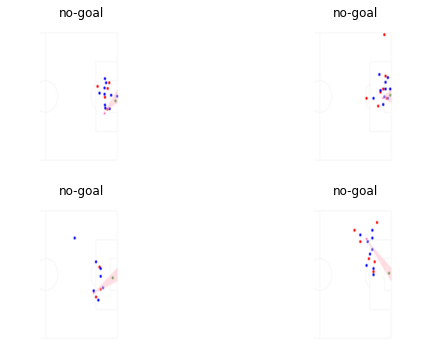

In [32]:
dls.show_batch(nrows=2, ncols=2, figsize=(9, 6))

In [4]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=1.9054607491852948e-06)

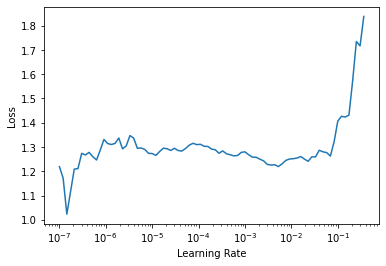

In [5]:
learn.lr_find()

In [6]:
learn.fit_one_cycle(5, slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.629289,0.425380,0.132353,0.867647,00:23
1,0.559527,0.360229,0.114164,0.885836,00:22
2,0.408125,0.294134,0.101393,0.898607,00:23
3,0.310652,0.246881,0.094427,0.905573,00:23
4,0.302833,0.232993,0.094427,0.905573,00:22


In [7]:
learn.unfreeze()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=9.12010818865383e-07)

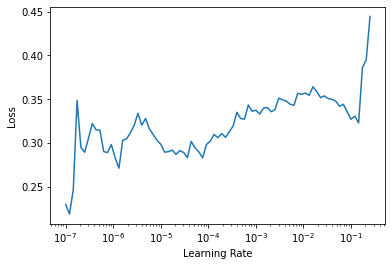

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(5, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.253828,0.219967,0.092492,0.907508,00:26
1,0.269846,0.189405,0.083978,0.916022,00:26
2,0.233778,0.173135,0.078560,0.921440,00:26
3,0.225681,0.159707,0.076625,0.923375,00:28
4,0.202534,0.158985,0.068885,0.931115,00:27


# Review the model

Make some predictions on the test-data.

First, let's go through predicting a single image...

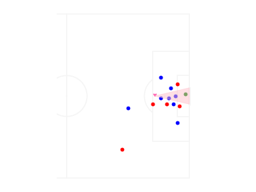

In [10]:
import PIL

# Load an image from the test data
test_img_dir = img_dir/'test'  # Path('../data/processed/temp/test')
example_img_path = (test_img_dir/'no-goal').ls()[1]
example_img = PILImage.create(example_img_path)

display(example_img.to_thumb(256, 256))

In [11]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

xG: 0.13730429112911224


Load all test data

In [12]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [13]:
import fastprogress
fastprogress.fastprogress.NO_BAR = True


def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = (test_img_dir/'goal').ls() + (test_img_dir/'no-goal').ls()
shots_predicted = [process_test_shot(s) for s in test_shots]

In [14]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

,path,id,is_goal,xg,sb_xg,diff
0,../data/processed/basic/test/goal/f1e09dc1-8ea1-493c-a295-de2f450acd94.png,f1e09dc1-8ea1-493c-a295-de2f450acd94,True,0.571707,0.188896,0.382811
1,../data/processed/basic/test/goal/ab097b1b-be53-47ca-b541-a4201bf1ecb4.png,ab097b1b-be53-47ca-b541-a4201bf1ecb4,True,0.479630,0.135544,0.344086
2,../data/processed/basic/test/goal/aa3da20c-cf80-40b3-b89e-0f113ffa5ccb.png,aa3da20c-cf80-40b3-b89e-0f113ffa5ccb,True,0.359143,0.433190,0.074047
3,../data/processed/basic/test/goal/967bef22-de45-4e6c-a0e4-349c0d904462.png,967bef22-de45-4e6c-a0e4-349c0d904462,True,0.520178,0.433026,0.087152
4,../data/processed/basic/test/goal/d8769961-69e4-43ce-a081-aa41be7136d6.png,d8769961-69e4-43ce-a081-aa41be7136d6,True,0.502884,0.296505,0.206379
...,...,...,...,...,...,...
2579,../data/processed/basic/test/no-goal/f396e4ca-3e47-4d81-8b7b-2404f29eb7f0.png,f396e4ca-3e47-4d81-8b7b-2404f29eb7f0,False,0.014975,0.055968,0.040994
2580,../data/processed/basic/test/no-goal/f172084b-827e-4139-9804-4f9160201138.png,f172084b-827e-4139-9804-4f9160201138,False,0.070358,0.022258,0.048099
2581,../data/processed/basic/test/no-goal/dc52c3e6-2fc2-490c-9d9f-dc7ddff1ca54.png,dc52c3e6-2fc2-490c-9d9f-dc7ddff1ca54,False,0.139771,0.067277,0.072493
2582,../data/processed/basic/test/no-goal/55de3730-785a-40d5-87a2-7a6acffa8140.png,55de3730-785a-40d5-87a2-7a6acffa8140,False,0.111017,0.056676,0.054341


Compare to SB xG

In [15]:
# Compare overall error rate between SB and image xG
import numpy as np


def mse(pred, obs):
    return np.mean((obs - pred)**2)


def rmse(pred, obs):
    return np.sqrt(mse(pred, obs))


def rmse_goal(pred):
    return rmse(pred, predictions['is_goal'])


def acc(pred, obs):
    return 1 - np.mean(obs - np.where(pred > 0.5, 1.0, 0.0))


def acc_goal(pred):
    return acc(pred, predictions['is_goal'])


def print_summary(pred):
    print((rmse_goal(pred), acc_goal(pred)))

for pred in [
    predictions['is_goal'].mean(),
    predictions['sb_xg'],
    predictions['xg'],
    (predictions['xg'] + predictions['sb_xg']) / 2
]:
    print_summary(pred)

(0.2971932135504584, 0.9020897832817337)
(0.26998703543851554, 0.9245356037151703)
(0.20883859052209447, 0.9311145510835913)
(0.23268629411470454, 0.9187306501547987)


ID: 29b99676-26c9-42ef-8d02-a12711f5426b
Im-xG: 0.81
SB-xG: 0.05
Goal: True
Diff:  0.76


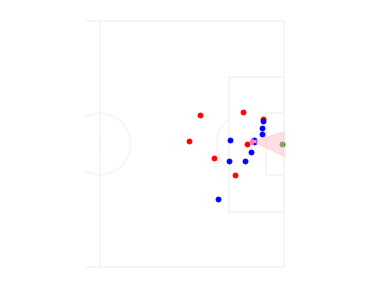

ID: 3b4338b4-a259-4175-96c3-8f1780f7a99e
Im-xG: 0.80
SB-xG: 0.07
Goal: True
Diff:  0.73


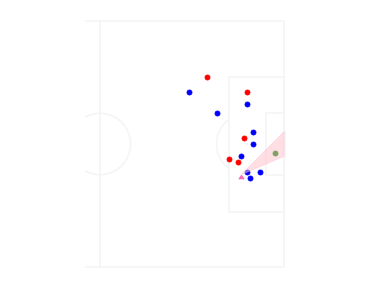

ID: 07bef15d-97ff-47ab-9650-a20b2cbae328
Im-xG: 0.75
SB-xG: 0.04
Goal: True
Diff:  0.71


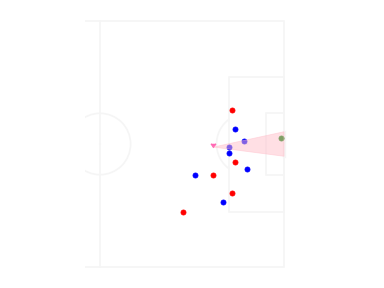

ID: 14992694-9125-4a8f-8ae4-32543ef10489
Im-xG: 0.68
SB-xG: 0.04
Goal: True
Diff:  0.64


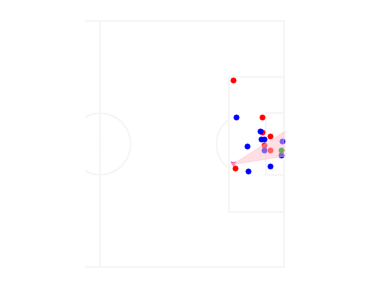

ID: 66f4c66b-0b26-4303-aad6-d749e16ba66c
Im-xG: 0.63
SB-xG: 0.03
Goal: True
Diff:  0.60


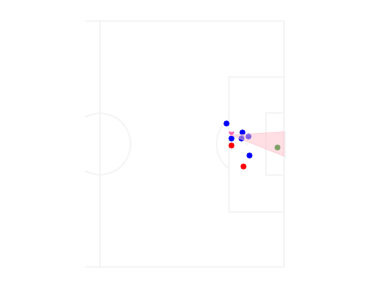

ID: d9b7ac2e-c553-4ee9-8e04-b89a47acfaa9
Im-xG: 0.77
SB-xG: 0.17
Goal: True
Diff:  0.60


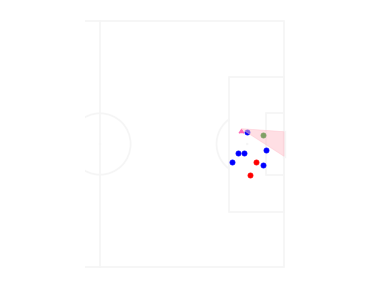

ID: 65ae34cf-5aa0-484d-9fc5-6e8bedbe5931
Im-xG: 0.65
SB-xG: 0.05
Goal: True
Diff:  0.60


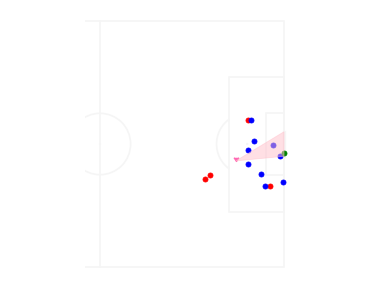

ID: 06845658-972c-4022-bef9-223be4835edd
Im-xG: 0.11
SB-xG: 0.71
Goal: False
Diff:  0.60


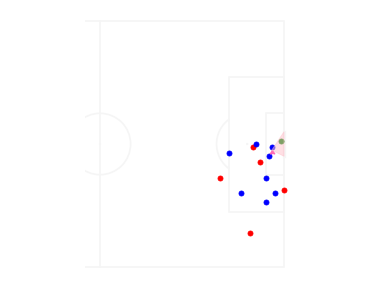

ID: 65bc9c6e-c916-4e7e-80ed-cd3908070b90
Im-xG: 0.22
SB-xG: 0.81
Goal: False
Diff:  0.59


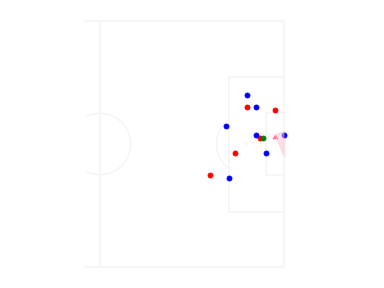

ID: 45806df4-1cf3-448a-9bab-43c6e0d7b6c4
Im-xG: 0.08
SB-xG: 0.61
Goal: False
Diff:  0.53


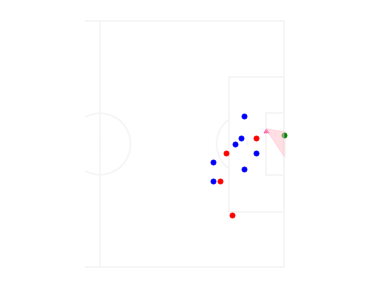

In [16]:
for _, p in predictions.sort_values(by='diff', ascending=False).head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

ID: f1e09dc1-8ea1-493c-a295-de2f450acd94
Im-xG: 0.57
SB-xG: 0.19
Goal: True
Diff:  0.38


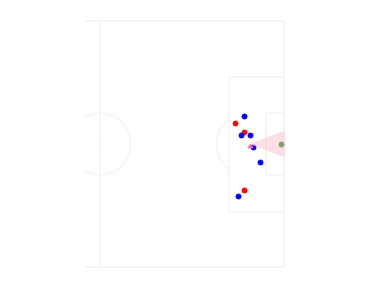

ID: de115b57-dc76-4489-ad4b-df20717e48ae
Im-xG: 0.29
SB-xG: 0.20
Goal: True
Diff:  0.09


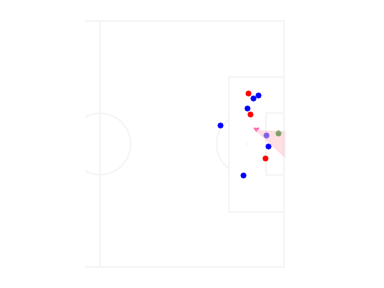

ID: 4033b905-83ae-4fe4-9efe-f88880c04271
Im-xG: 0.62
SB-xG: 0.21
Goal: True
Diff:  0.41


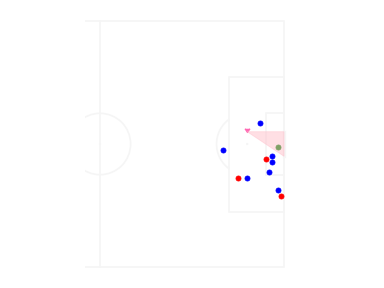

ID: 3b7b429c-3cea-4342-9da3-3021f129f302
Im-xG: 0.38
SB-xG: 0.20
Goal: True
Diff:  0.19


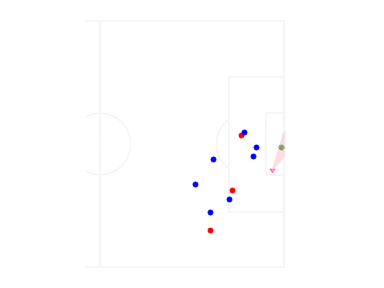

ID: 93ec0a33-ff35-429c-8538-dd6368e7cc9d
Im-xG: 0.42
SB-xG: 0.20
Goal: True
Diff:  0.21


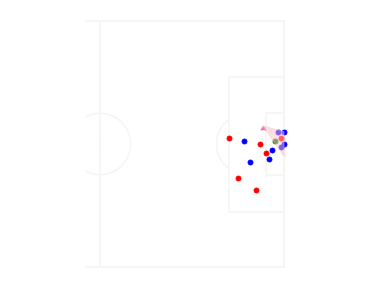

ID: 4710b288-763b-4bee-8a8d-3b18ad9a5bed
Im-xG: 0.25
SB-xG: 0.18
Goal: True
Diff:  0.06


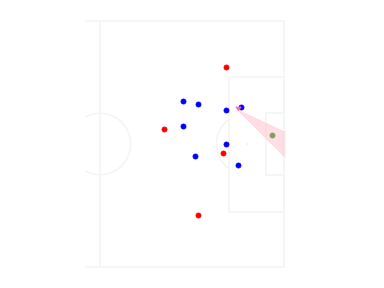

ID: caeac5cb-e813-41ae-847b-8c79603b8496
Im-xG: 0.34
SB-xG: 0.19
Goal: True
Diff:  0.15


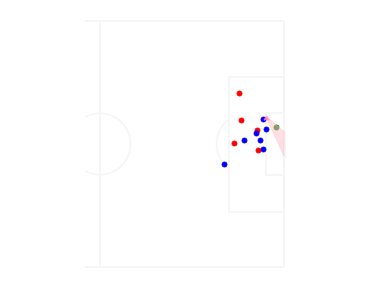

ID: 458ce8f4-aa3e-4e44-8880-60ece5bbfe21
Im-xG: 0.32
SB-xG: 0.22
Goal: True
Diff:  0.10


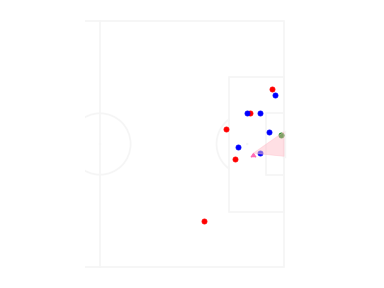

ID: 307b9496-6160-403e-a7b6-867c2f048ab1
Im-xG: 0.35
SB-xG: 0.18
Goal: True
Diff:  0.17


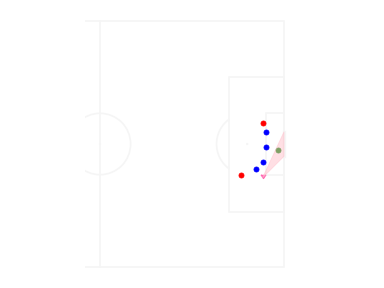

ID: c2109858-a9e3-435e-ad86-af3c042ec301
Im-xG: 0.40
SB-xG: 0.19
Goal: True
Diff:  0.21


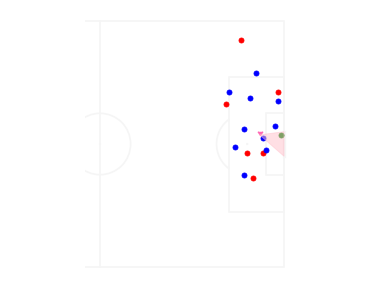

ID: 0243eefb-307d-4d7a-b1e3-8970f171b7e0
Im-xG: 0.50
SB-xG: 0.19
Goal: True
Diff:  0.32


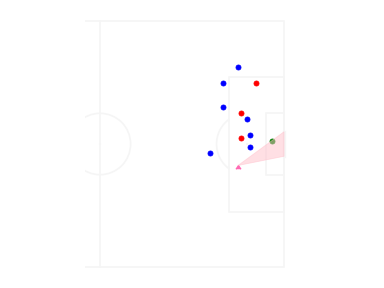

ID: 17f1f2d8-e98b-41c9-8ddb-7ce92237055f
Im-xG: 0.53
SB-xG: 0.21
Goal: True
Diff:  0.32


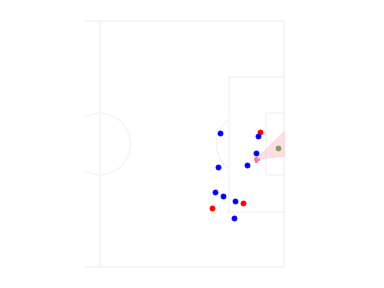

ID: 87f6698c-2247-4abe-81fe-c61f83d48c74
Im-xG: 0.54
SB-xG: 0.21
Goal: True
Diff:  0.33


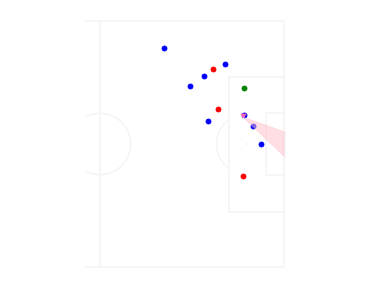

ID: 255e3b64-a49c-488f-af27-fadc4a7533bd
Im-xG: 0.35
SB-xG: 0.20
Goal: True
Diff:  0.15


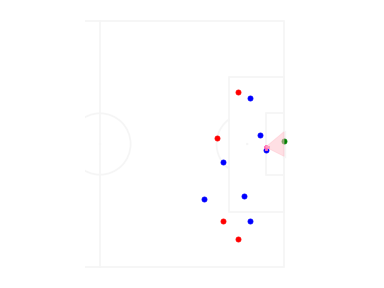

ID: 8dc5dc3f-8238-4c32-8709-c412c18ef55a
Im-xG: 0.26
SB-xG: 0.20
Goal: True
Diff:  0.06


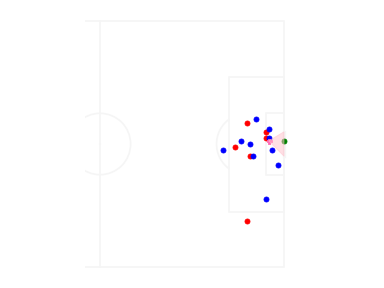

ID: c5976e08-e311-4860-9e56-0f53ffe6a7b5
Im-xG: 0.36
SB-xG: 0.19
Goal: True
Diff:  0.16


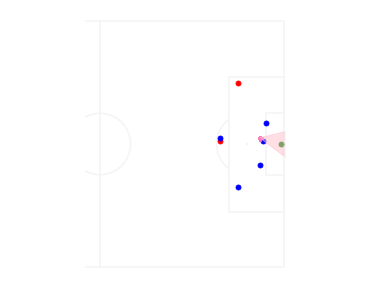

ID: 5c89bd7a-a148-40e4-aaf7-1e07dd7ab229
Im-xG: 0.29
SB-xG: 0.19
Goal: False
Diff:  0.10


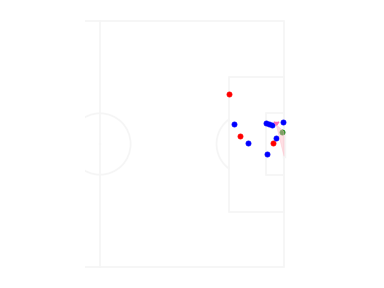

ID: be762e52-6173-4422-af66-cf5fda8746f1
Im-xG: 0.16
SB-xG: 0.20
Goal: False
Diff:  0.04


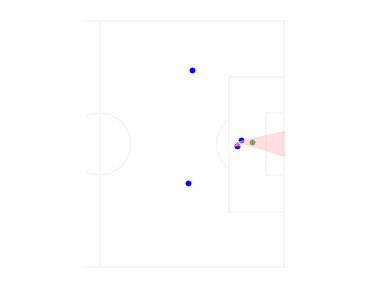

ID: 56c8fe42-1d4f-4074-9f43-0f4640d3bf7f
Im-xG: 0.06
SB-xG: 0.20
Goal: False
Diff:  0.14


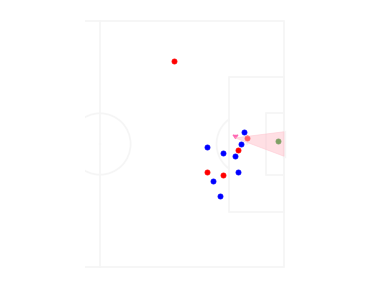

ID: 724cc6ed-584f-48a2-a915-704673c9c4e2
Im-xG: 0.07
SB-xG: 0.21
Goal: False
Diff:  0.14


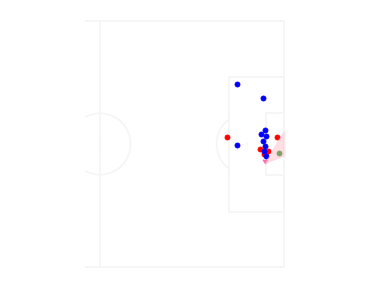

ID: 2a5d71a0-760a-457a-b8a1-bad7c918854e
Im-xG: 0.06
SB-xG: 0.18
Goal: False
Diff:  0.12


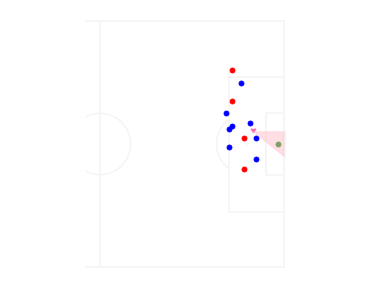

ID: ef71f022-787d-4952-a803-11c56531e1de
Im-xG: 0.07
SB-xG: 0.22
Goal: False
Diff:  0.14


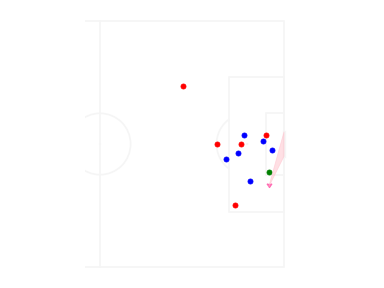

ID: aac510a0-9190-4d41-811f-1517599ec3fd
Im-xG: 0.07
SB-xG: 0.19
Goal: False
Diff:  0.12


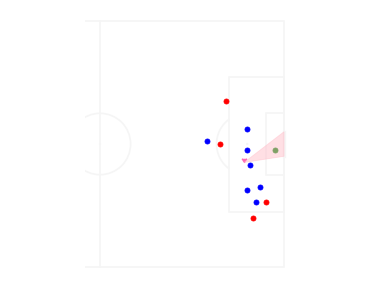

ID: 37392fa1-01b9-4e75-914c-63d59807abe0
Im-xG: 0.14
SB-xG: 0.22
Goal: False
Diff:  0.08


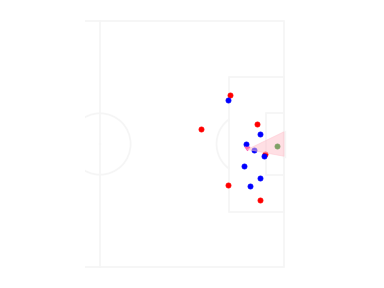

ID: d4ca74c6-ef13-4ca7-9c33-90ca215523d8
Im-xG: 0.09
SB-xG: 0.20
Goal: False
Diff:  0.11


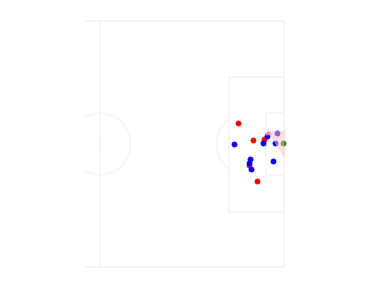

ID: 6fdc77a8-9c4c-404a-8365-de32fdcaa28a
Im-xG: 0.03
SB-xG: 0.20
Goal: False
Diff:  0.17


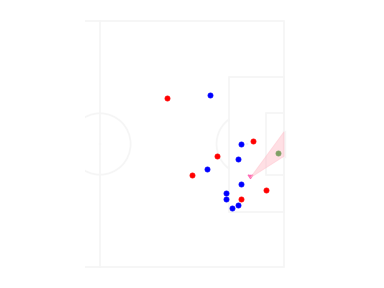

ID: b76b90ea-49f6-41c7-ba13-0ea54ba2b7a9
Im-xG: 0.11
SB-xG: 0.20
Goal: False
Diff:  0.09


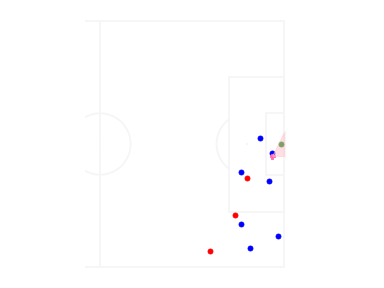

ID: 00a62828-1a02-4129-95aa-00f99276e000
Im-xG: 0.32
SB-xG: 0.22
Goal: False
Diff:  0.10


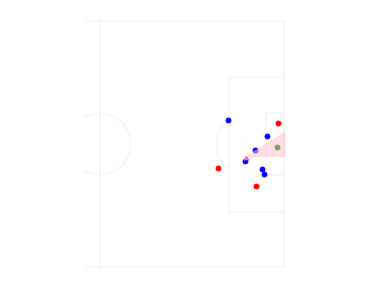

ID: c1db5e56-b29c-4869-955e-82124106d63d
Im-xG: 0.05
SB-xG: 0.19
Goal: False
Diff:  0.14


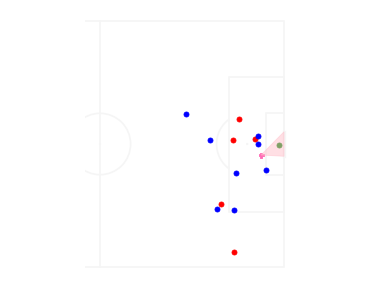

ID: b554ca60-1335-4175-b777-11ab3d3b0710
Im-xG: 0.11
SB-xG: 0.20
Goal: False
Diff:  0.09


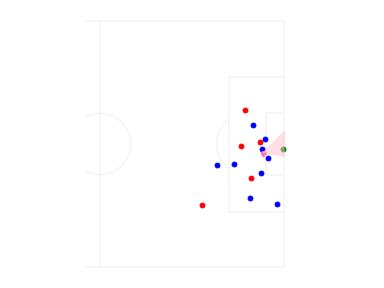

ID: 0fbee275-301e-4a73-a25f-37b88d213d92
Im-xG: 0.34
SB-xG: 0.20
Goal: False
Diff:  0.13


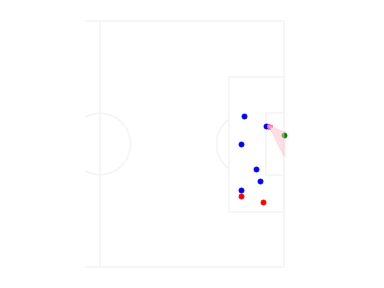

ID: d1e0bb21-3793-47dc-a9d8-be8ebdfb69a3
Im-xG: 0.06
SB-xG: 0.20
Goal: False
Diff:  0.15


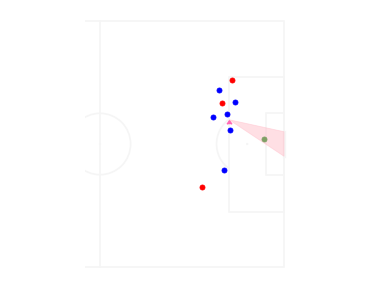

ID: 47db34d9-ba8a-407d-b145-36008157e01b
Im-xG: 0.17
SB-xG: 0.18
Goal: False
Diff:  0.01


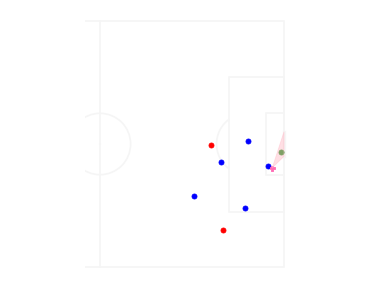

ID: 2d72fb1c-e6e9-4f0b-ba55-829132da4cd5
Im-xG: 0.09
SB-xG: 0.21
Goal: False
Diff:  0.12


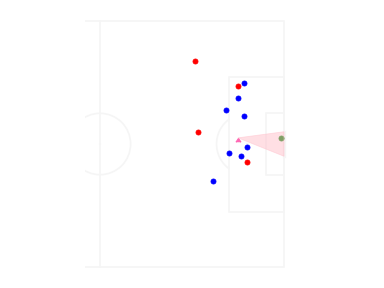

ID: 64fb106d-153b-4919-adad-ee604dbad2f3
Im-xG: 0.16
SB-xG: 0.20
Goal: False
Diff:  0.04


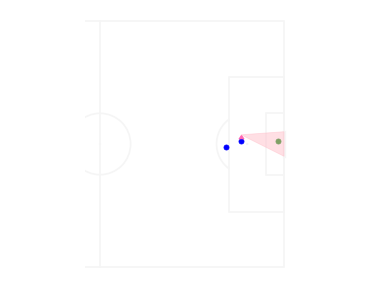

ID: 3cf4dc65-3f26-4a5c-9fbc-a9fa3a6c9d2f
Im-xG: 0.08
SB-xG: 0.20
Goal: False
Diff:  0.13


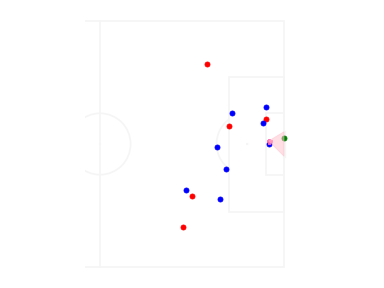

ID: 9d8ee429-c805-4388-a2f5-c6b6b09a125b
Im-xG: 0.06
SB-xG: 0.20
Goal: False
Diff:  0.15


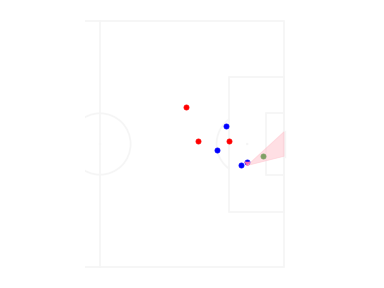

ID: d8a3a02c-caba-412d-a0d9-3b2b16e6929c
Im-xG: 0.07
SB-xG: 0.20
Goal: False
Diff:  0.13


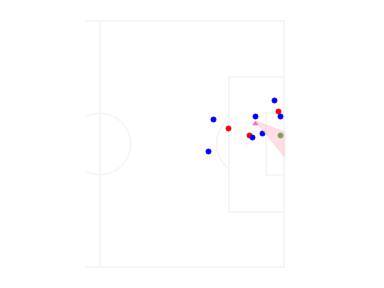

ID: cf24d8ba-740c-4fdd-a0a1-33375948cf19
Im-xG: 0.08
SB-xG: 0.20
Goal: False
Diff:  0.12


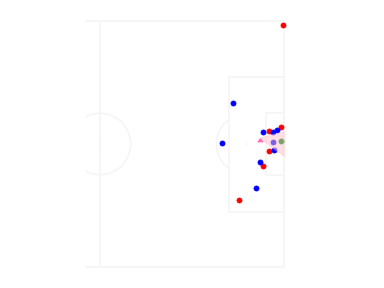

ID: e612930f-fb23-4432-8ae6-1a27962560af
Im-xG: 0.04
SB-xG: 0.19
Goal: False
Diff:  0.15


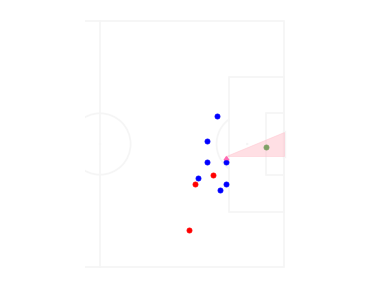

ID: 3cc60806-3242-4253-bd8f-36682ad408e5
Im-xG: 0.05
SB-xG: 0.21
Goal: False
Diff:  0.16


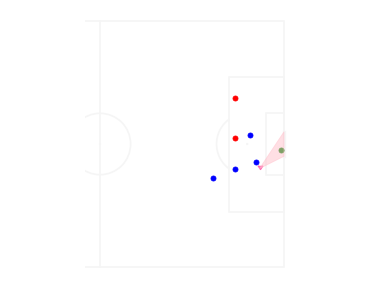

ID: 52c4c338-1178-4d9a-91f1-c013e1af8d92
Im-xG: 0.02
SB-xG: 0.22
Goal: False
Diff:  0.20


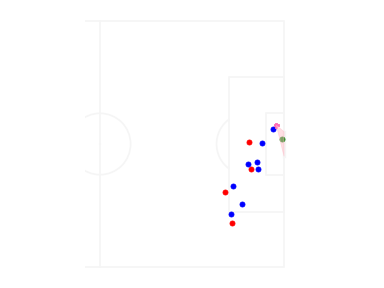

ID: 56c8c20e-eb70-4862-a98a-ae1c83f330a3
Im-xG: 0.18
SB-xG: 0.18
Goal: False
Diff:  0.01


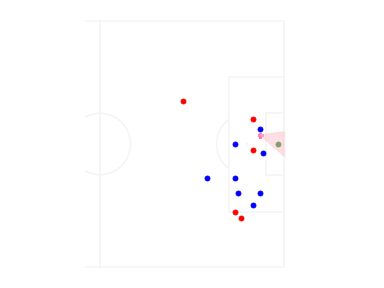

ID: 79ee4daf-2907-4b9d-8c68-65dfbcd227e1
Im-xG: 0.06
SB-xG: 0.18
Goal: False
Diff:  0.12


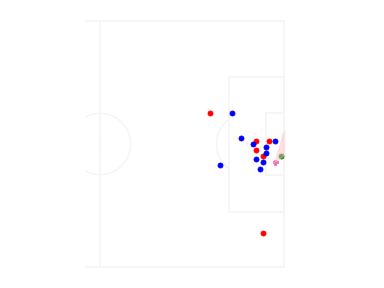

ID: a21229c6-17ac-4460-9025-59359a488132
Im-xG: 0.08
SB-xG: 0.21
Goal: False
Diff:  0.13


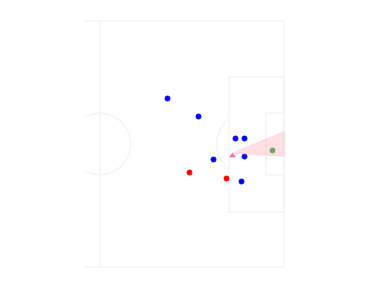

ID: b94a14cc-de65-4231-a99b-26a736a39080
Im-xG: 0.08
SB-xG: 0.19
Goal: False
Diff:  0.11


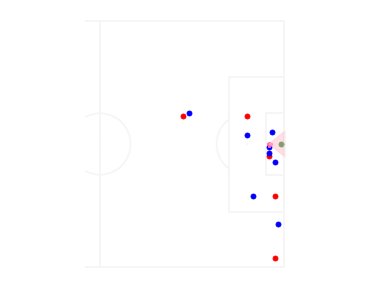

ID: b674bbb7-82d1-464a-bc16-950cfb9c4fd7
Im-xG: 0.12
SB-xG: 0.22
Goal: False
Diff:  0.09


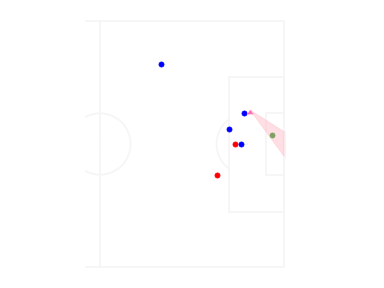

ID: 4e888491-4cea-4a51-bc0e-d3cd59ea91ef
Im-xG: 0.06
SB-xG: 0.21
Goal: False
Diff:  0.15


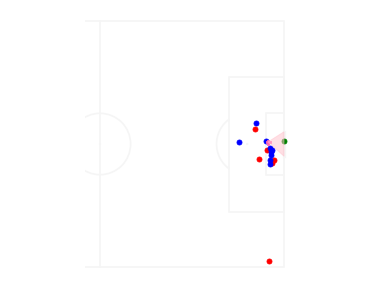

ID: 91040889-b270-437d-9c12-f3dbd440de3f
Im-xG: 0.03
SB-xG: 0.18
Goal: False
Diff:  0.15


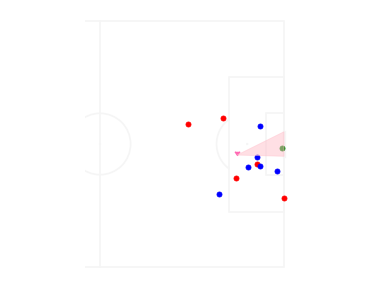

ID: 01a4398d-001f-4bbc-9226-d372988f5781
Im-xG: 0.19
SB-xG: 0.18
Goal: False
Diff:  0.00


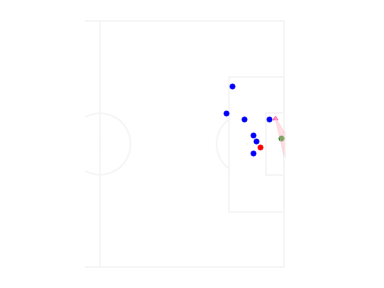

ID: a9173120-f17e-4cc3-aa32-447ef92e6cb4
Im-xG: 0.08
SB-xG: 0.18
Goal: False
Diff:  0.10


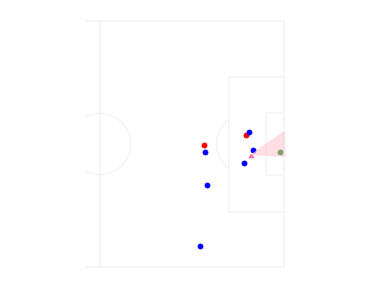

ID: adae704d-2c49-49e4-80cf-27878e394ef4
Im-xG: 0.17
SB-xG: 0.19
Goal: False
Diff:  0.02


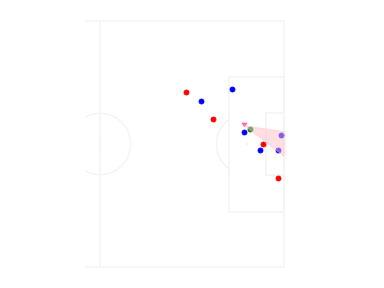

ID: 00df025c-1050-4a2e-9cdc-87d7f274a8aa
Im-xG: 0.11
SB-xG: 0.21
Goal: False
Diff:  0.10


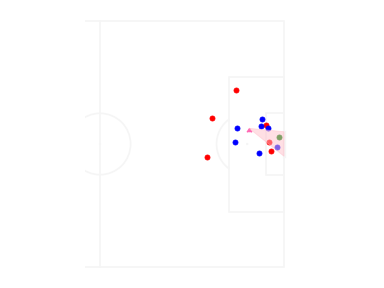

ID: 4dedd031-37db-44b9-9229-3098123ee343
Im-xG: 0.08
SB-xG: 0.20
Goal: False
Diff:  0.12


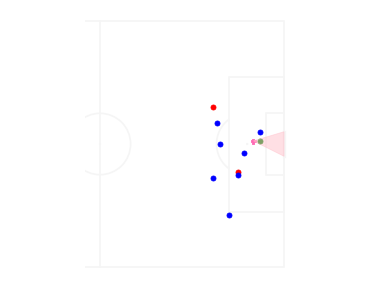

ID: b78a9850-6f12-48dc-ab45-12d903553e2f
Im-xG: 0.14
SB-xG: 0.22
Goal: False
Diff:  0.08


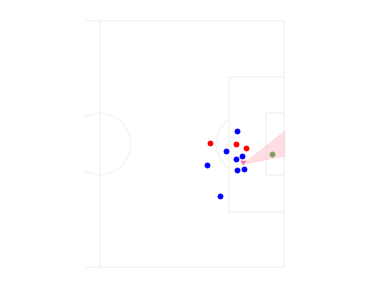

ID: bcca6876-3daf-4be8-96bb-38574dd27229
Im-xG: 0.13
SB-xG: 0.21
Goal: False
Diff:  0.08


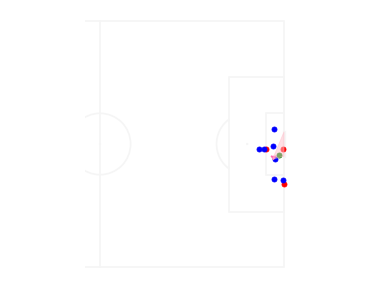

ID: 8ec00e70-620f-47c2-b709-5a2604fa5364
Im-xG: 0.06
SB-xG: 0.21
Goal: False
Diff:  0.15


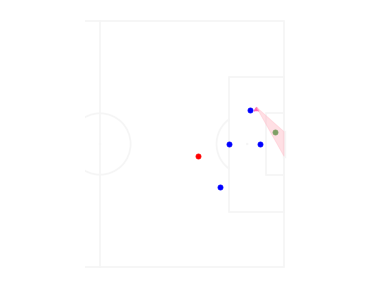

ID: 228a933d-861d-4485-ad96-3f78ce43bea5
Im-xG: 0.13
SB-xG: 0.21
Goal: False
Diff:  0.08


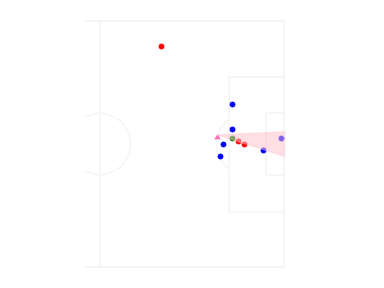

ID: 575c5e66-33f5-4e4d-aef5-77db2cb47332
Im-xG: 0.17
SB-xG: 0.19
Goal: False
Diff:  0.02


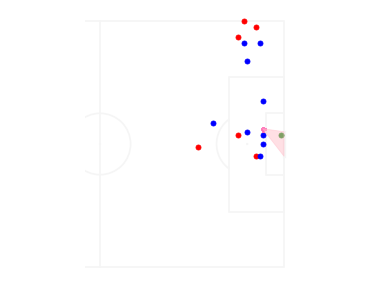

ID: bc0c4bf4-0e01-4349-8622-a4a9ccbe4ef9
Im-xG: 0.03
SB-xG: 0.19
Goal: False
Diff:  0.16


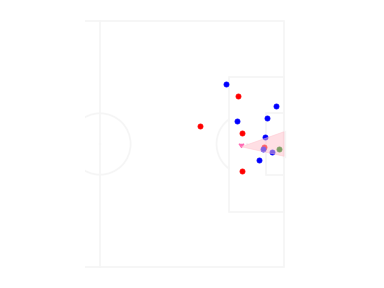

ID: a0f64338-6d29-4cf7-afd9-2a8aec491126
Im-xG: 0.13
SB-xG: 0.18
Goal: False
Diff:  0.06


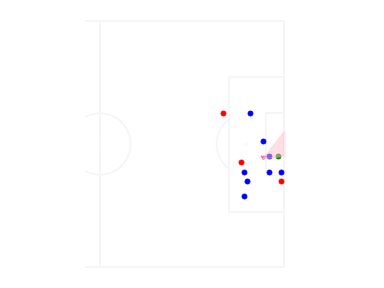

ID: 60d95ee9-b174-4a8f-abcc-914dae61426a
Im-xG: 0.04
SB-xG: 0.21
Goal: False
Diff:  0.17


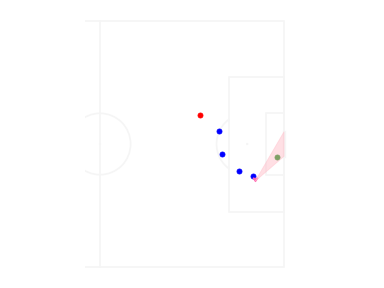

ID: d4b6a125-1060-4589-89d3-f16c53a7cce9
Im-xG: 0.06
SB-xG: 0.18
Goal: False
Diff:  0.13


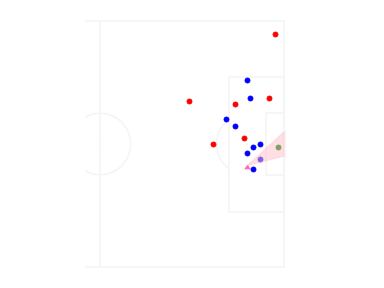

ID: c99b57d6-72cb-4100-a60a-1e9fb9b7433c
Im-xG: 0.10
SB-xG: 0.20
Goal: False
Diff:  0.10


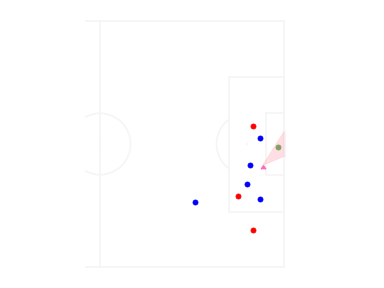

ID: 439ac9ec-1fcb-4a5e-87b6-e0777363eb28
Im-xG: 0.11
SB-xG: 0.20
Goal: False
Diff:  0.09


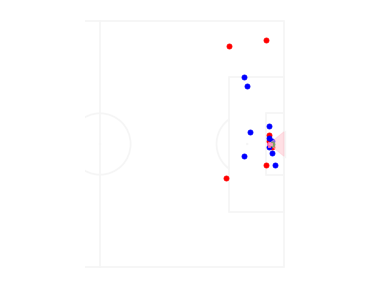

ID: 035c378c-a3f8-47f6-aaca-ba38922a2400
Im-xG: 0.10
SB-xG: 0.18
Goal: False
Diff:  0.08


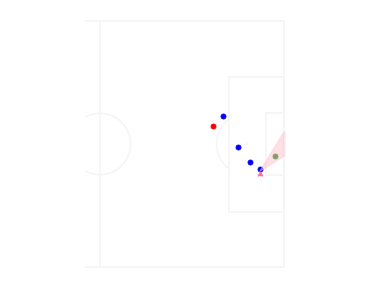

ID: b0f3df70-8cd5-4203-bc2c-d048685e5dd5
Im-xG: 0.13
SB-xG: 0.19
Goal: False
Diff:  0.06


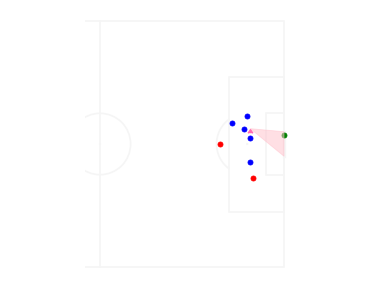

ID: 926e2a21-0b20-4361-95b0-30cd59dd4f6e
Im-xG: 0.13
SB-xG: 0.21
Goal: False
Diff:  0.08


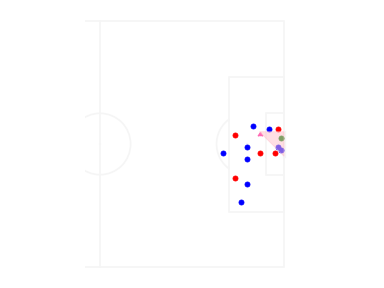

ID: ca111176-6203-47af-a588-a0318f5ae5e5
Im-xG: 0.10
SB-xG: 0.18
Goal: False
Diff:  0.08


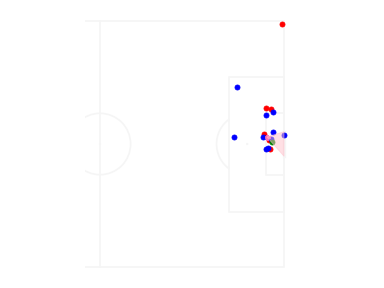

ID: e00cdb0a-78d5-42ea-8d94-c6eeb393b4d8
Im-xG: 0.10
SB-xG: 0.22
Goal: False
Diff:  0.12


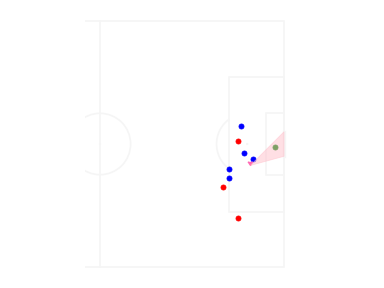

ID: 6b72a34b-37d2-4047-9f33-2d874aeb0295
Im-xG: 0.08
SB-xG: 0.20
Goal: False
Diff:  0.12


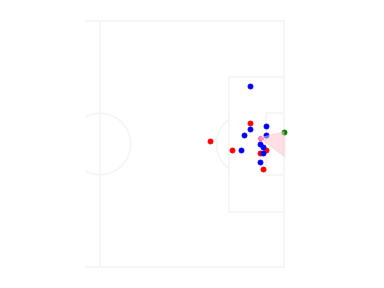

ID: dd4b2072-3c9a-4fe0-a2b8-07af0c07cfbe
Im-xG: 0.14
SB-xG: 0.20
Goal: False
Diff:  0.06


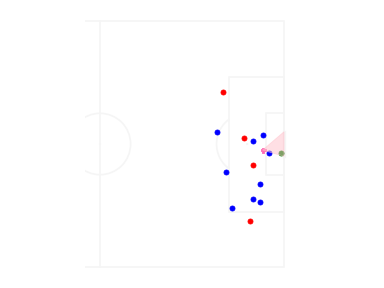

ID: 52020e34-49e7-499b-aace-e1b16331bfa2
Im-xG: 0.10
SB-xG: 0.22
Goal: False
Diff:  0.11


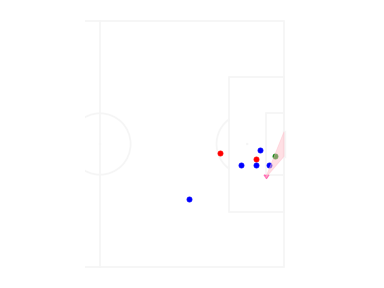

ID: 1f705d2a-8d6d-4d98-b09b-88a922b6d890
Im-xG: 0.02
SB-xG: 0.20
Goal: False
Diff:  0.18


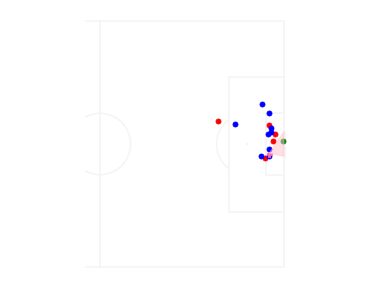

ID: 4623b26f-4c72-4bbb-bf94-9a752cd45e0a
Im-xG: 0.21
SB-xG: 0.18
Goal: False
Diff:  0.03


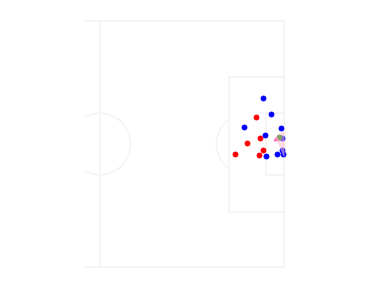

ID: a495a12d-f7a1-4b92-b92d-5bd6daa28c63
Im-xG: 0.16
SB-xG: 0.20
Goal: False
Diff:  0.03


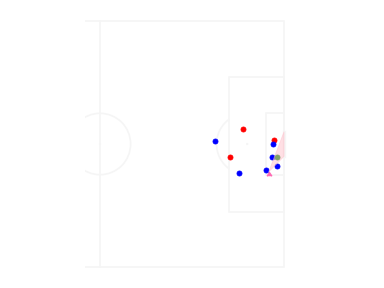

ID: 1fd4863b-127d-49ac-b284-5b0db1cc260a
Im-xG: 0.11
SB-xG: 0.21
Goal: False
Diff:  0.10


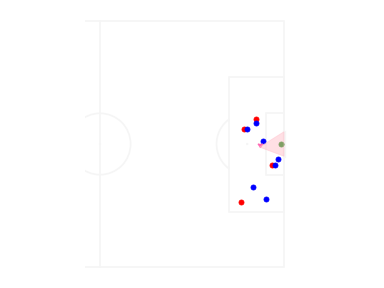

ID: d26b7a2c-ab07-4621-8cec-b6b516d565d0
Im-xG: 0.26
SB-xG: 0.19
Goal: False
Diff:  0.06


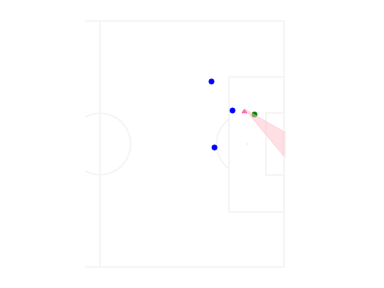

ID: af80c17a-8f8f-4ce6-a23b-34209fe3e11a
Im-xG: 0.06
SB-xG: 0.21
Goal: False
Diff:  0.15


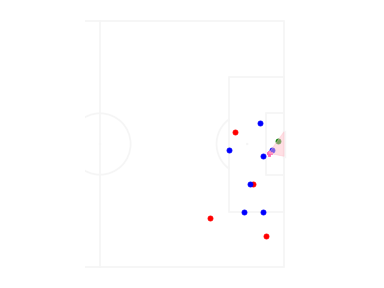

ID: a5ac42d6-cc5d-4909-a561-1bea0a8ee02a
Im-xG: 0.10
SB-xG: 0.19
Goal: False
Diff:  0.09


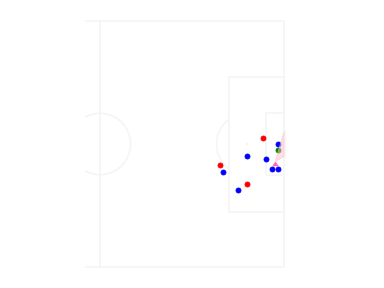

ID: 9ca96dab-7d71-4d9e-a6fa-16341869e3da
Im-xG: 0.11
SB-xG: 0.19
Goal: False
Diff:  0.08


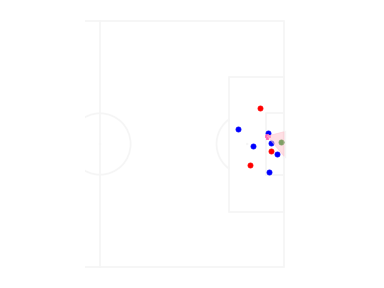

ID: e91c97fa-b058-4348-947f-4f81cf051b7f
Im-xG: 0.11
SB-xG: 0.20
Goal: False
Diff:  0.09


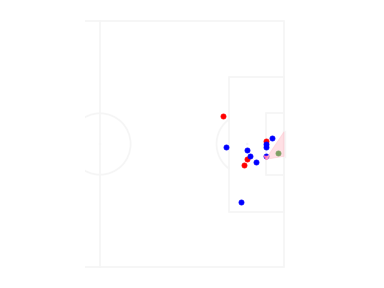

ID: b5014c8f-581b-417a-b9b5-f641c3334a66
Im-xG: 0.01
SB-xG: 0.21
Goal: False
Diff:  0.20


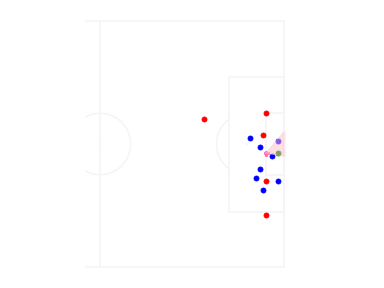

ID: ddfe28e6-29b3-435d-acdc-cbbab6f5134f
Im-xG: 0.13
SB-xG: 0.19
Goal: False
Diff:  0.06


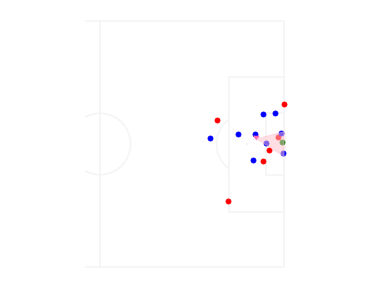

ID: 17cf77b9-253e-4c67-95e7-7fa670ba21c4
Im-xG: 0.12
SB-xG: 0.20
Goal: False
Diff:  0.08


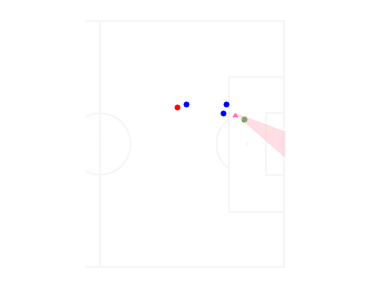

In [17]:
for _, p in predictions.loc[lambda df: (df['sb_xg'] < 0.22) & (df['sb_xg'] > 0.18)].iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

ID: e9abea35-4d72-4f7d-8920-36a1c40a6149
Im-xG: 0.45
SB-xG: 0.05
Goal: False
Diff:  0.40


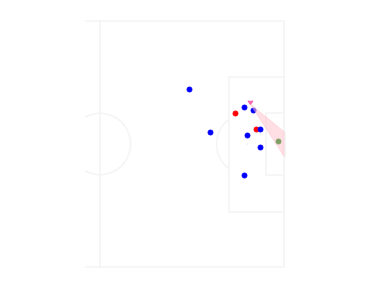

ID: 80578fbb-2bbd-4e6f-918e-b96109d62092
Im-xG: 0.37
SB-xG: 0.08
Goal: False
Diff:  0.28


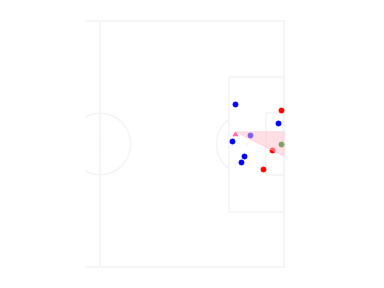

ID: 8d02ca9d-41f1-4ec0-81e2-6fe9429792dd
Im-xG: 0.35
SB-xG: 0.24
Goal: False
Diff:  0.12


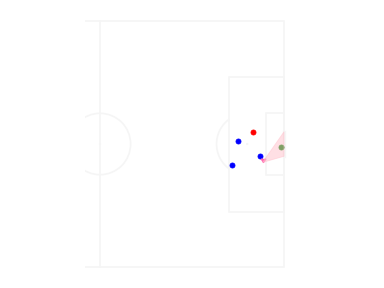

ID: 450adb53-ae5e-4e3f-a82d-eb6280057721
Im-xG: 0.35
SB-xG: 0.07
Goal: False
Diff:  0.28


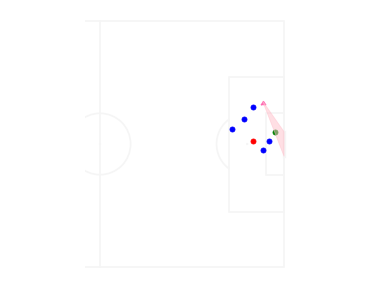

ID: 00555d1a-ab63-499c-90cc-9ca29928c84f
Im-xG: 0.35
SB-xG: 0.10
Goal: False
Diff:  0.25


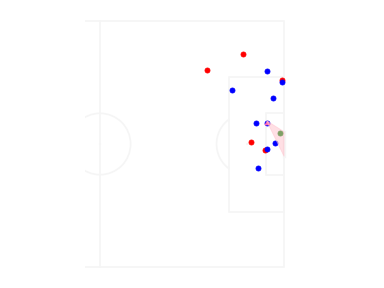

ID: 26020d1b-7ad1-4553-ac97-72c9ce6554ac
Im-xG: 0.34
SB-xG: 0.09
Goal: False
Diff:  0.25


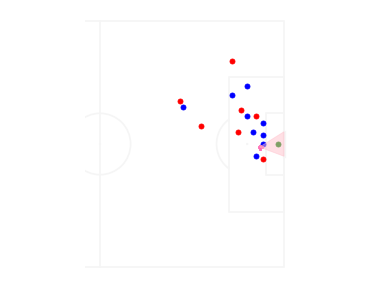

ID: ee2e028e-ef04-4508-9a5b-5c1c889743e7
Im-xG: 0.34
SB-xG: 0.06
Goal: False
Diff:  0.28


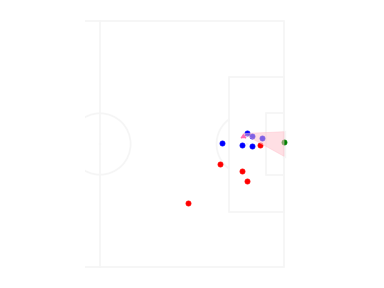

ID: c1b01dd1-1ab3-4a76-afbc-b6598654178b
Im-xG: 0.34
SB-xG: 0.81
Goal: False
Diff:  0.47


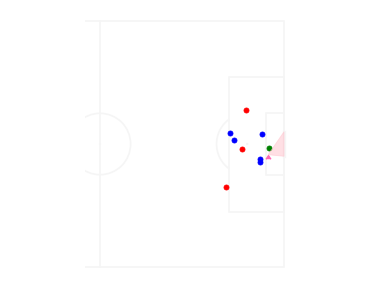

ID: 9cee1476-8aaf-4e79-a522-838f1d071b17
Im-xG: 0.34
SB-xG: 0.09
Goal: False
Diff:  0.25


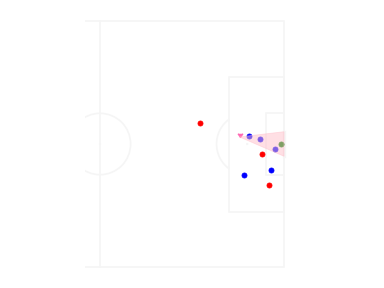

ID: 29516244-77fd-46da-8439-b82ac165190b
Im-xG: 0.34
SB-xG: 0.02
Goal: False
Diff:  0.32


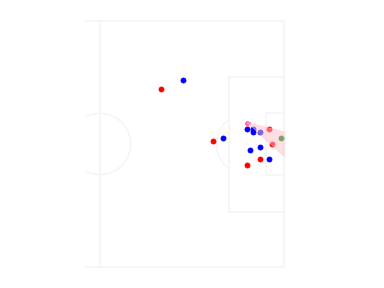

ID: 0fbee275-301e-4a73-a25f-37b88d213d92
Im-xG: 0.34
SB-xG: 0.20
Goal: False
Diff:  0.13


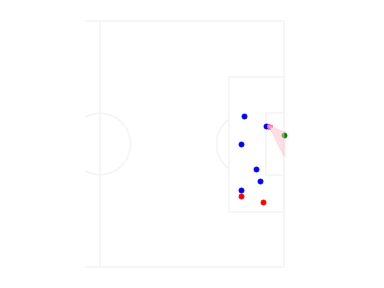

ID: ae666905-0627-412d-a817-55cbe26263d3
Im-xG: 0.33
SB-xG: 0.03
Goal: False
Diff:  0.30


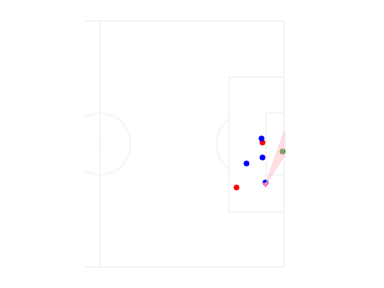

ID: b9b3beca-b223-4390-8ba8-4c3d78bbd06a
Im-xG: 0.33
SB-xG: 0.10
Goal: False
Diff:  0.23


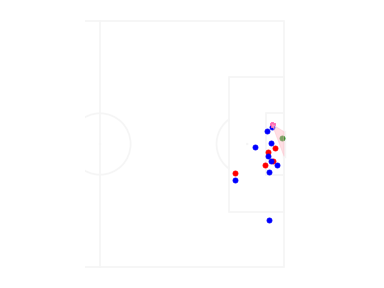

ID: ce8ef533-306d-4fd2-b49d-6bfda5abf3dd
Im-xG: 0.32
SB-xG: 0.04
Goal: False
Diff:  0.29


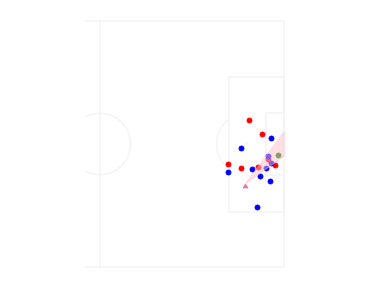

ID: 118207d4-1395-4651-80d6-77a95b2920f6
Im-xG: 0.32
SB-xG: 0.10
Goal: False
Diff:  0.23


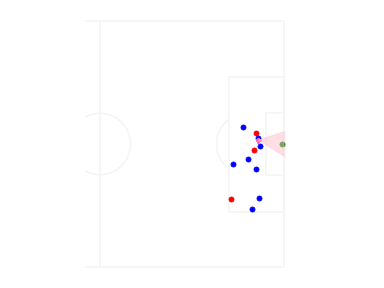

In [18]:
for _, p in predictions.loc[lambda df: ~df['is_goal']].sort_values(by='xg', ascending=False).head(15).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

<AxesSubplot:xlabel='xg', ylabel='sb_xg'>

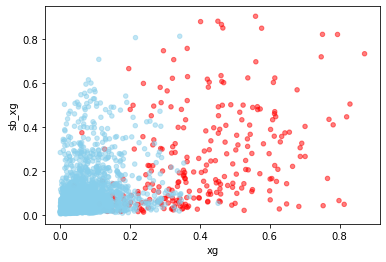

In [19]:
predictions.assign(
    is_goal=lambda df: df['is_goal'].map({False:'skyblue', True:'red'})
).plot(
    x='xg', y='sb_xg', c='is_goal', kind='scatter', alpha=0.5
)

<AxesSubplot:xlabel='xg', ylabel='is_goal'>

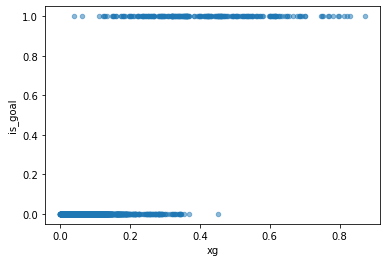

In [34]:
predictions.assign(
    is_goal=lambda df: df['is_goal'].astype(int)
).plot(x='xg', y='is_goal', kind='scatter', alpha=0.5)


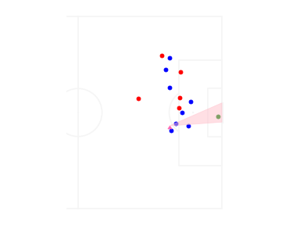
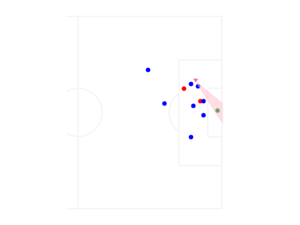


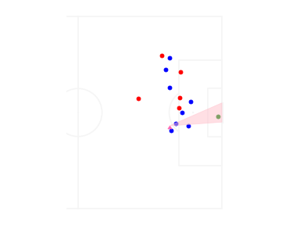
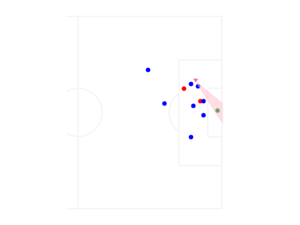


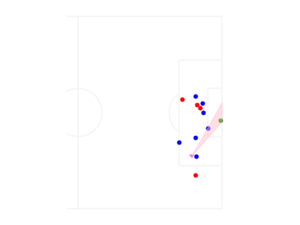
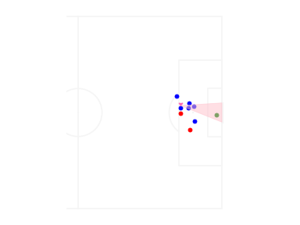


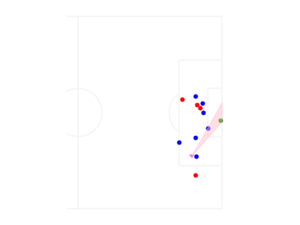
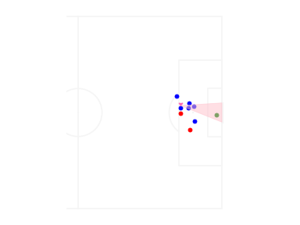


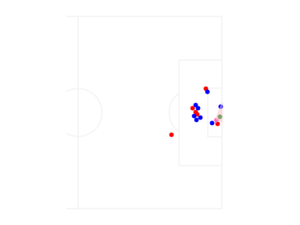
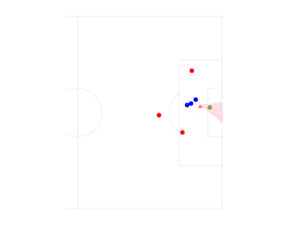


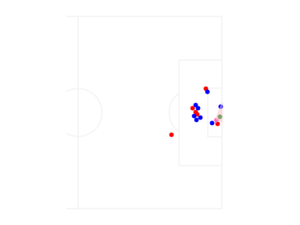
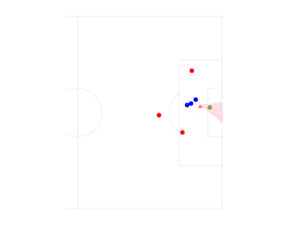


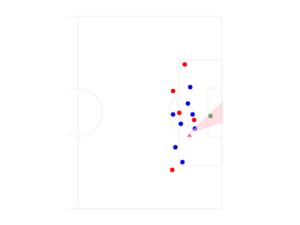
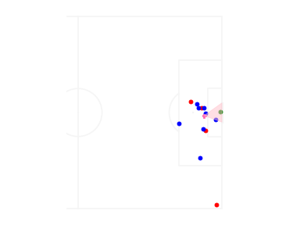


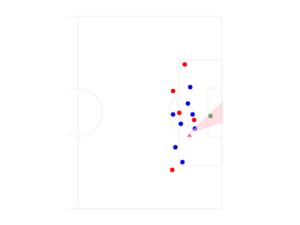
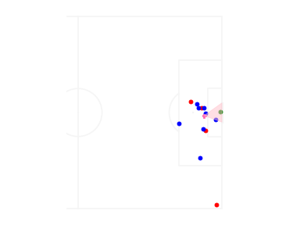


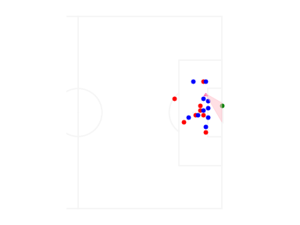
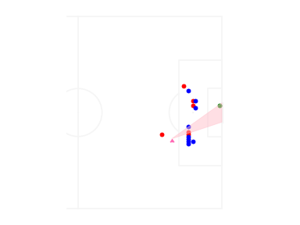


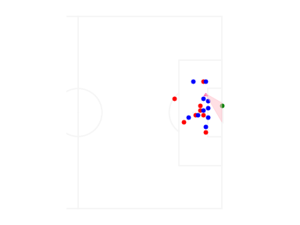
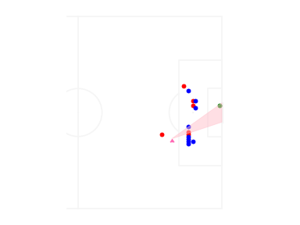


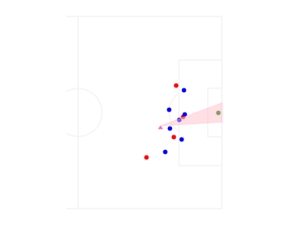
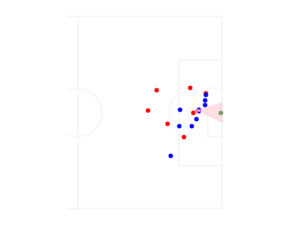


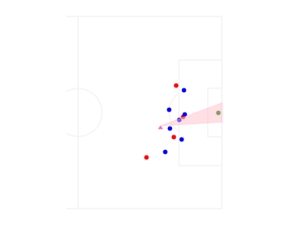
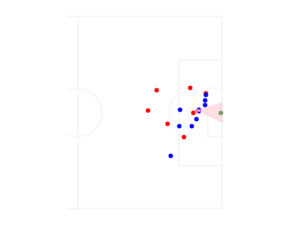


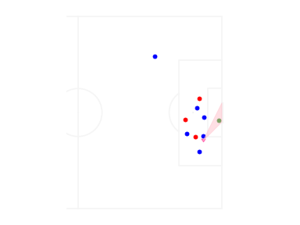
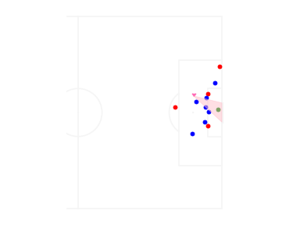


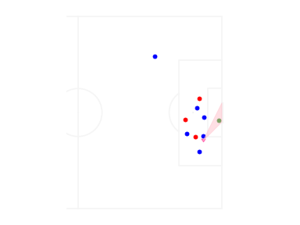
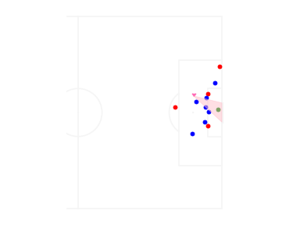


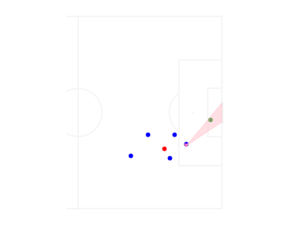
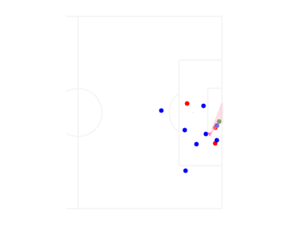


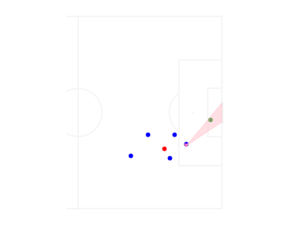
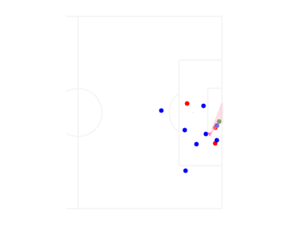


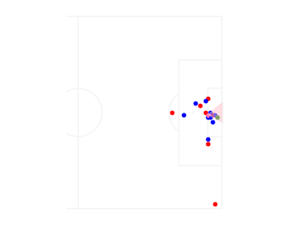
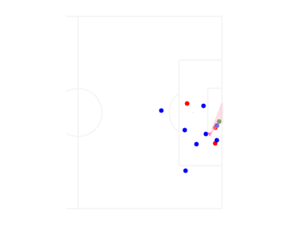


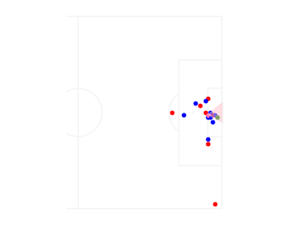
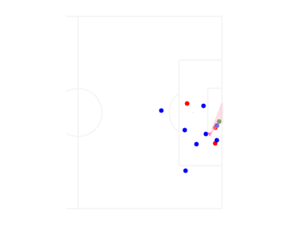


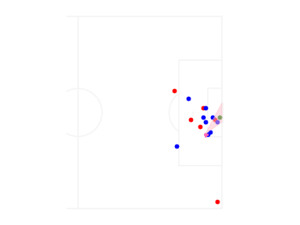
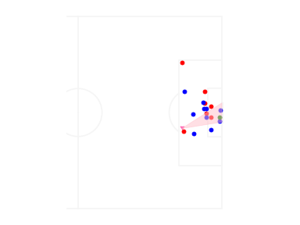


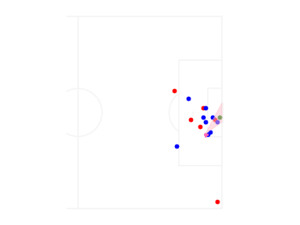
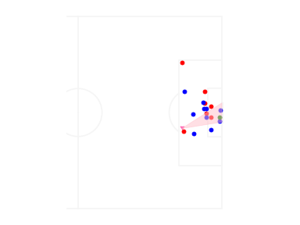


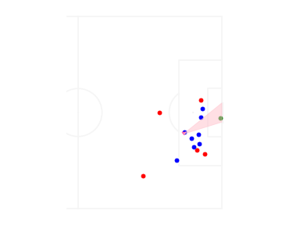
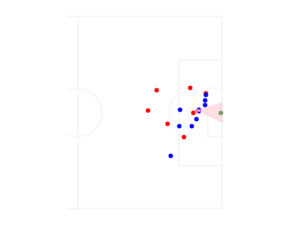


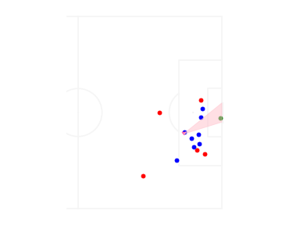
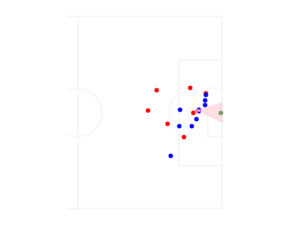


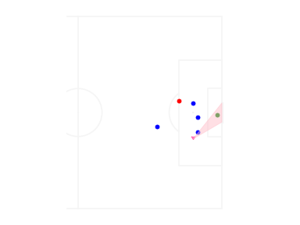
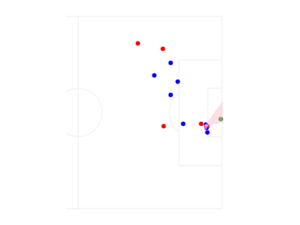


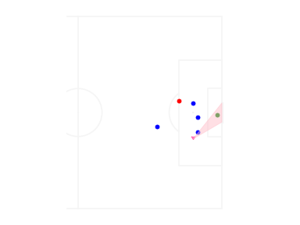
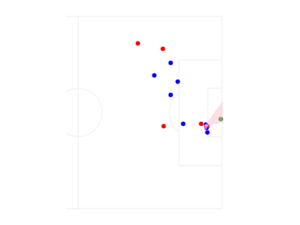


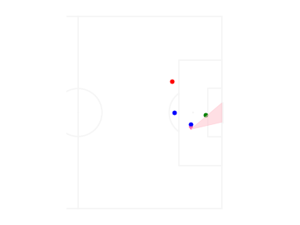
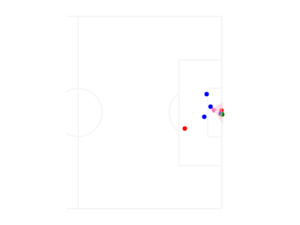


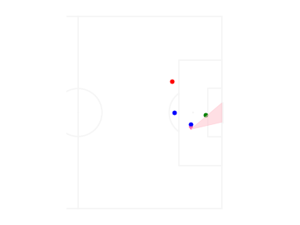
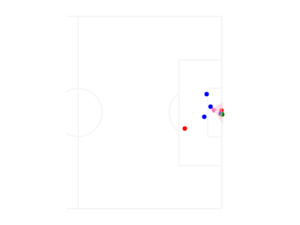


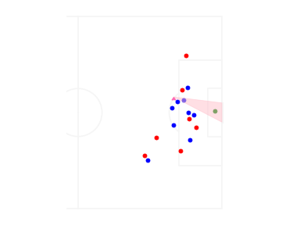
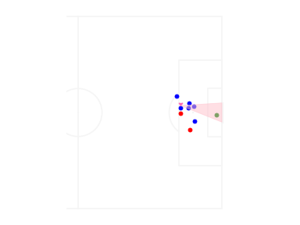


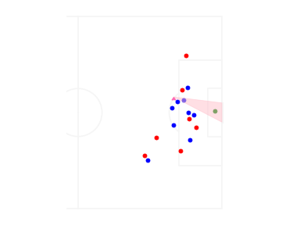
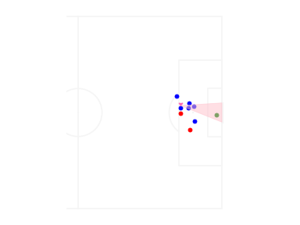


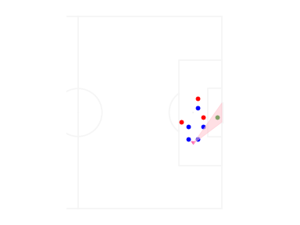
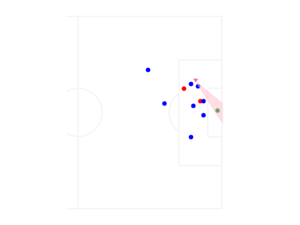


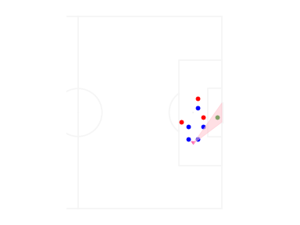
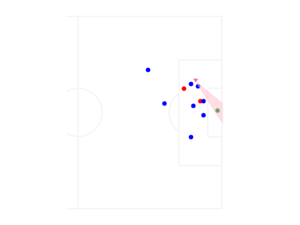


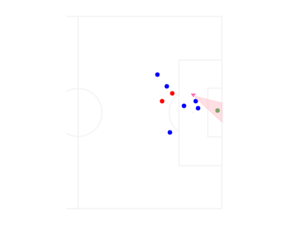
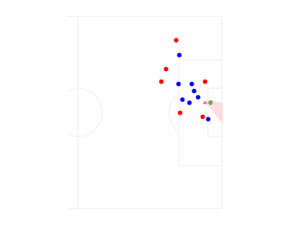


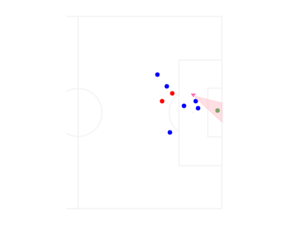
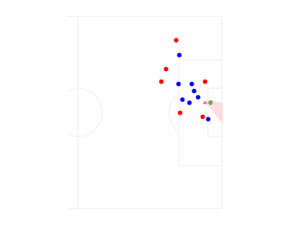


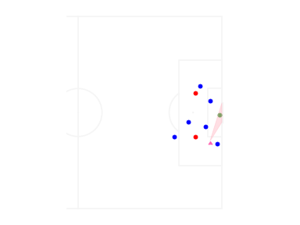
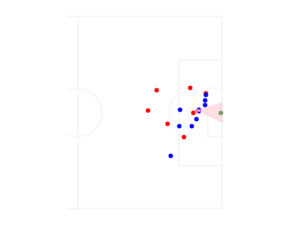


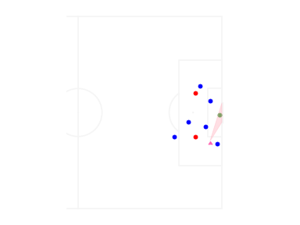
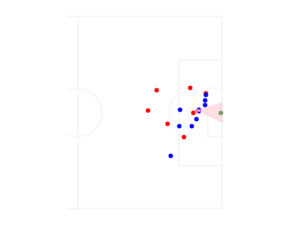


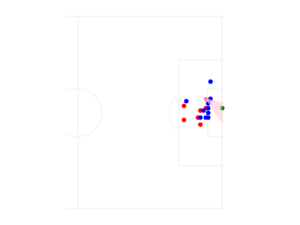
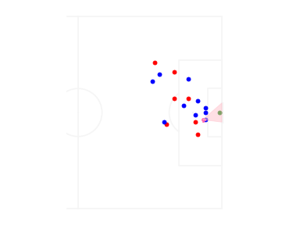


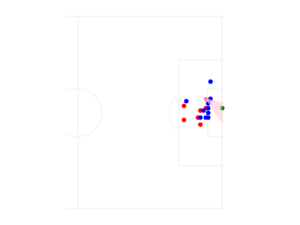
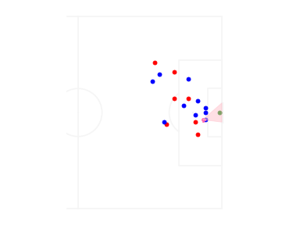


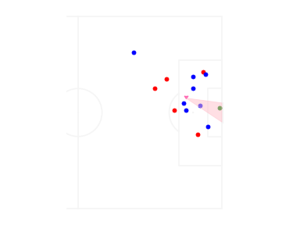
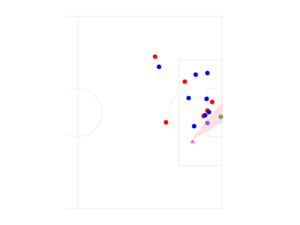


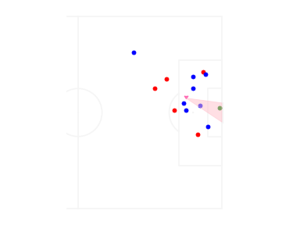
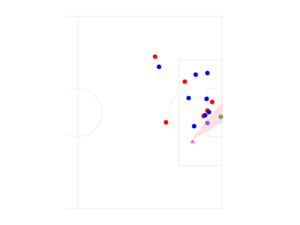


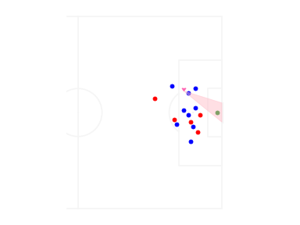
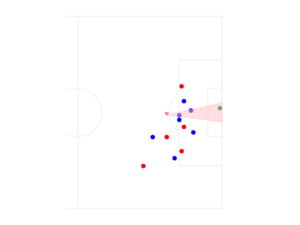


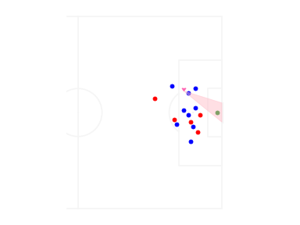
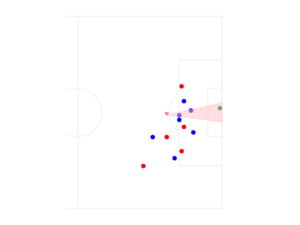


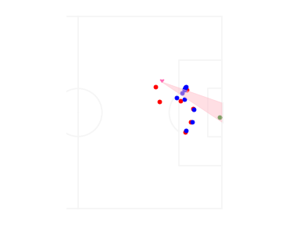
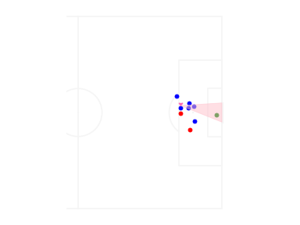


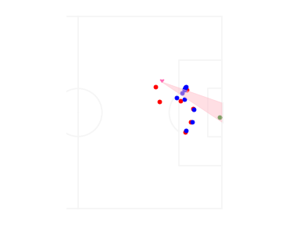
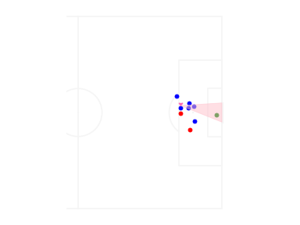


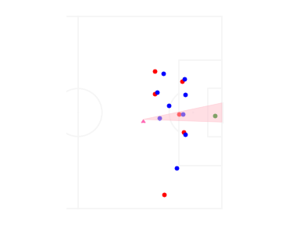
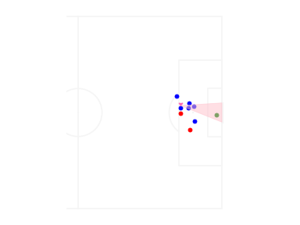


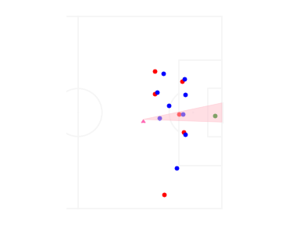
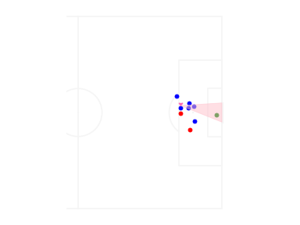


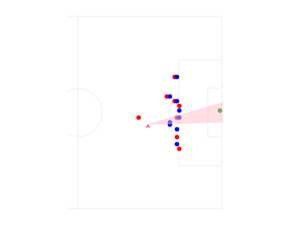
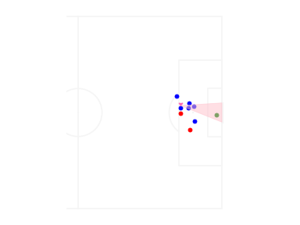


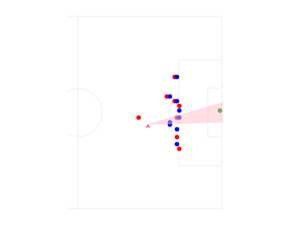
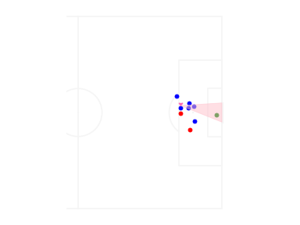


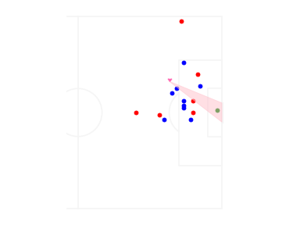
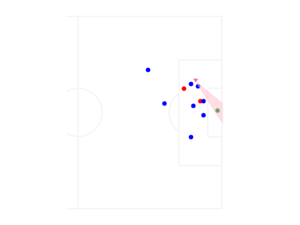


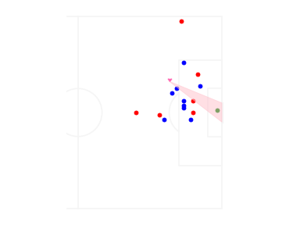
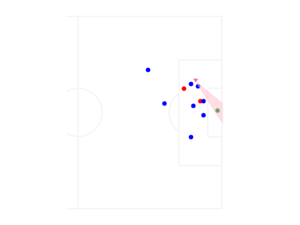


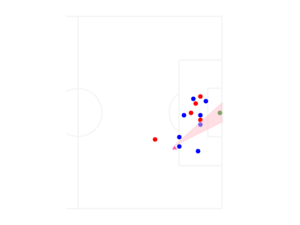
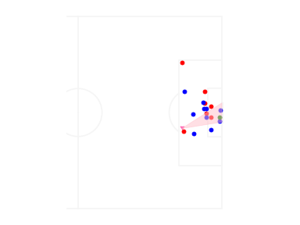


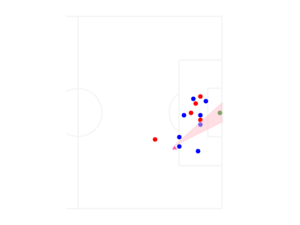
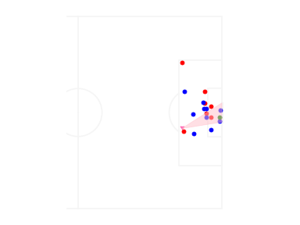


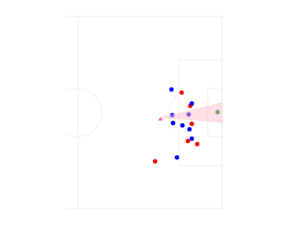
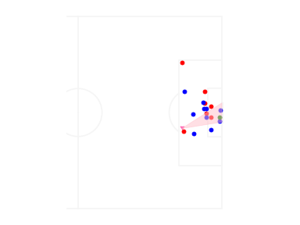


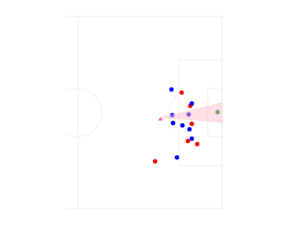
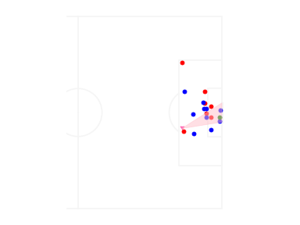


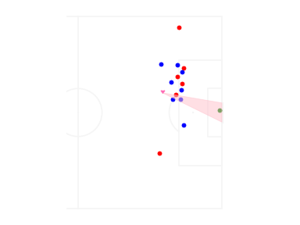
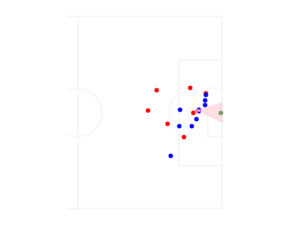


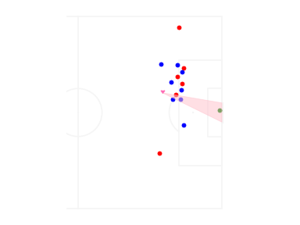
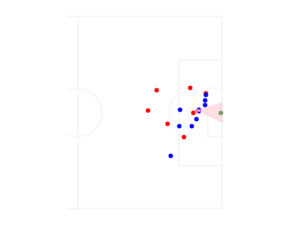


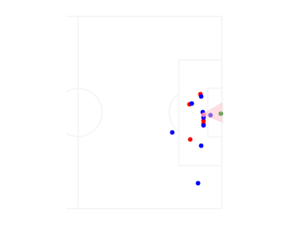
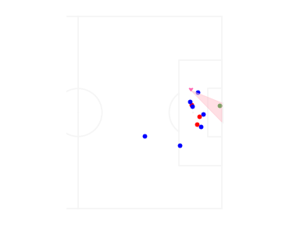


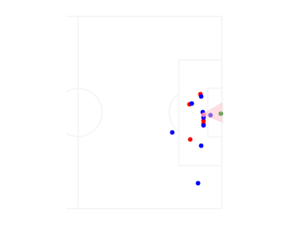
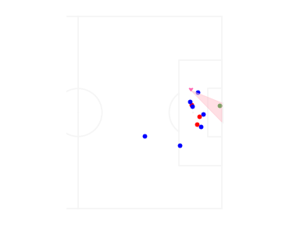


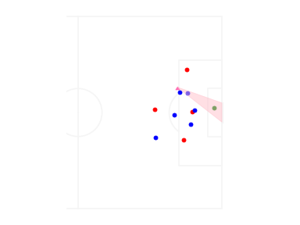
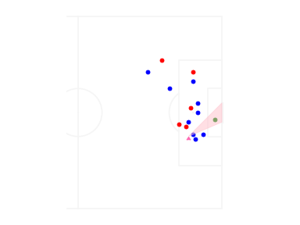


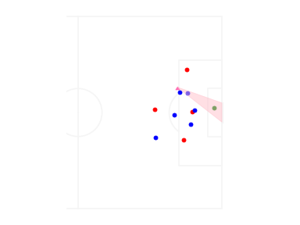
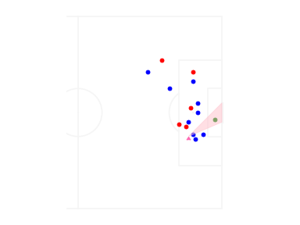


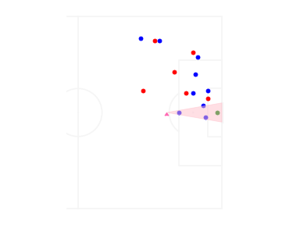
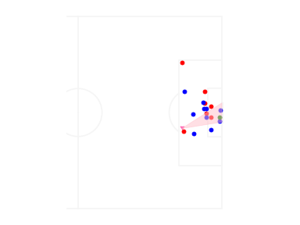


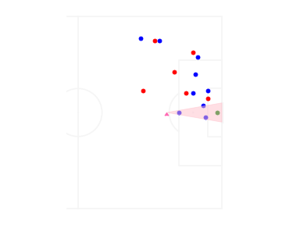
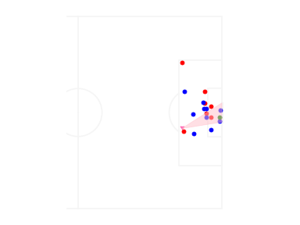


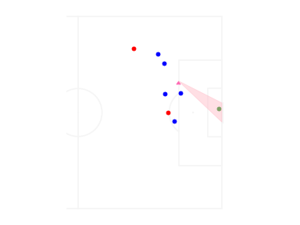
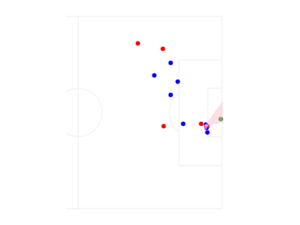


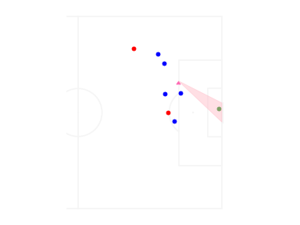
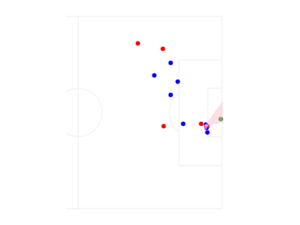


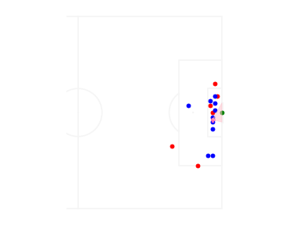
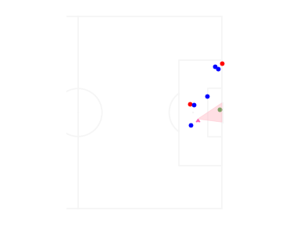


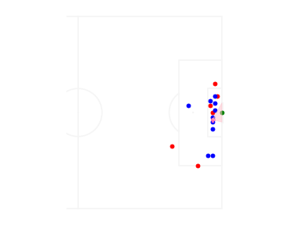
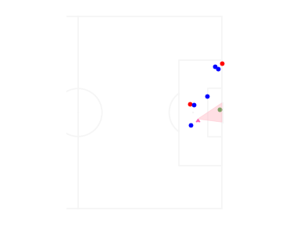


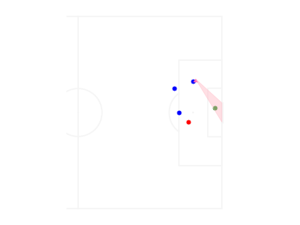
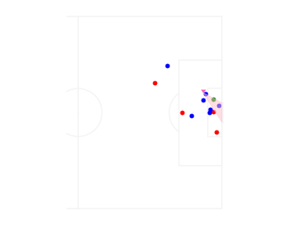


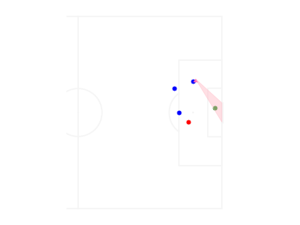
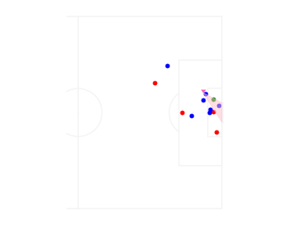


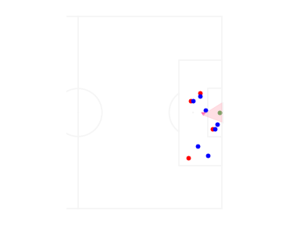
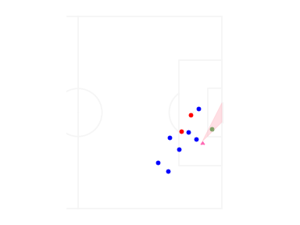


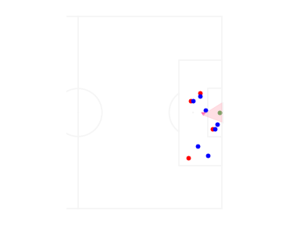
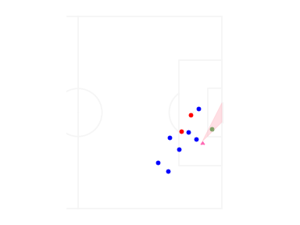


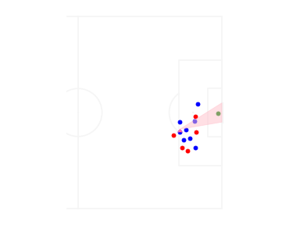
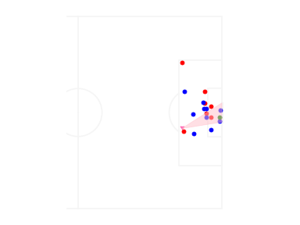


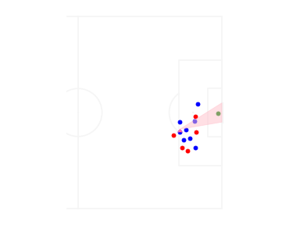
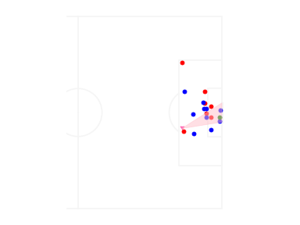


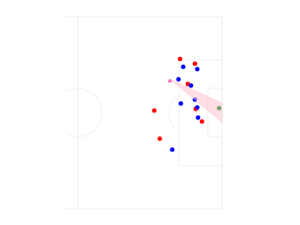
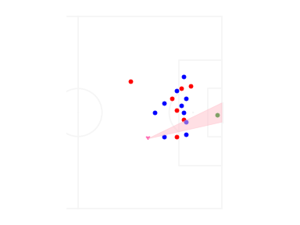


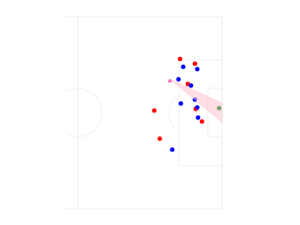
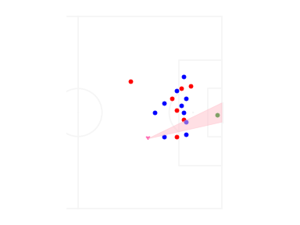


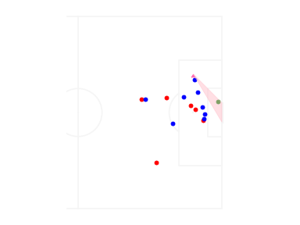
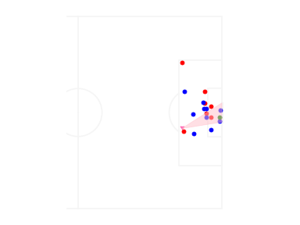


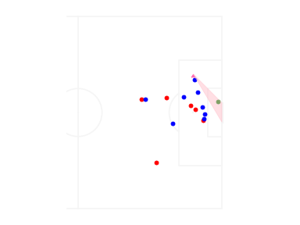
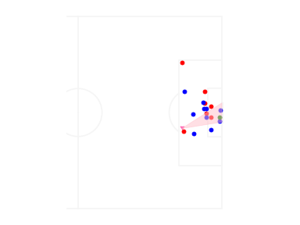


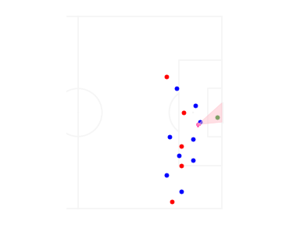
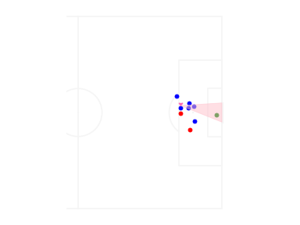


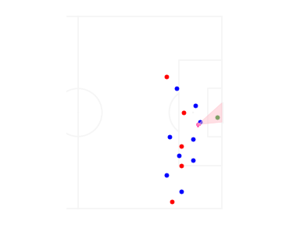
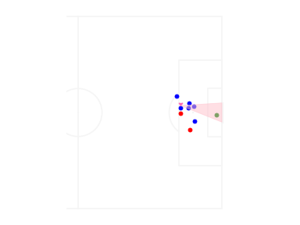


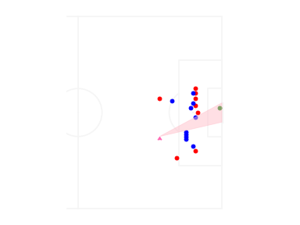
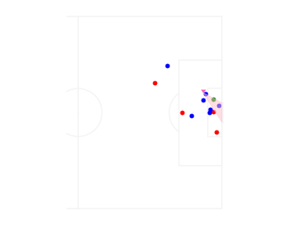


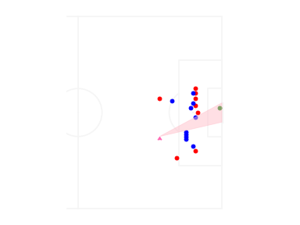
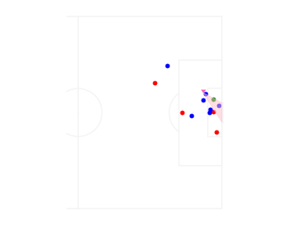


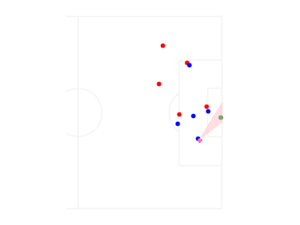
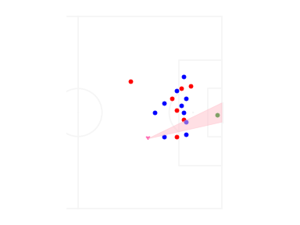


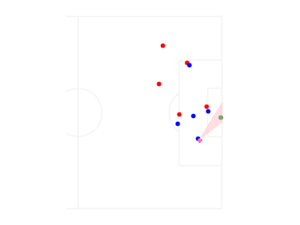
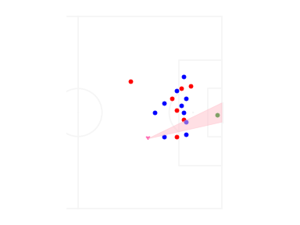


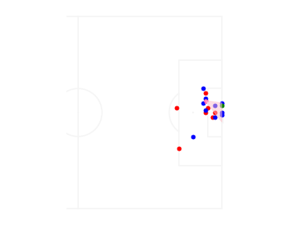
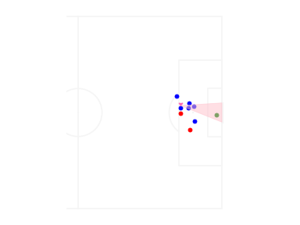


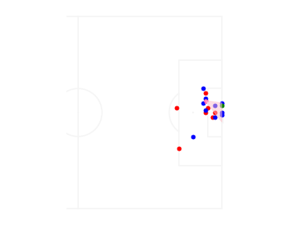
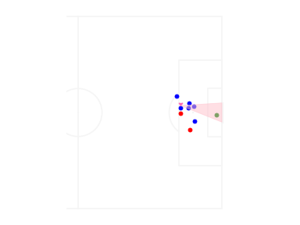


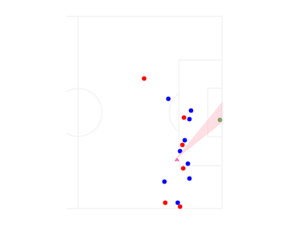
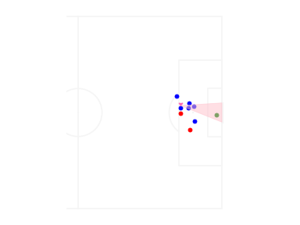


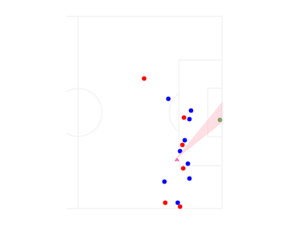
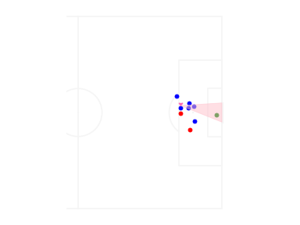


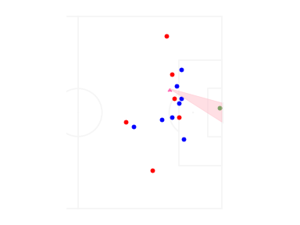
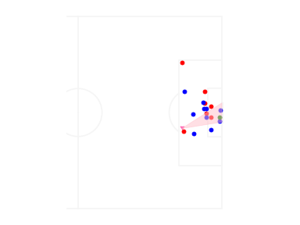


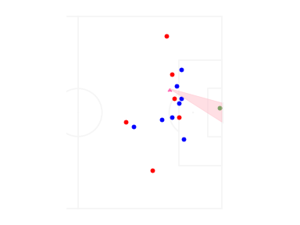
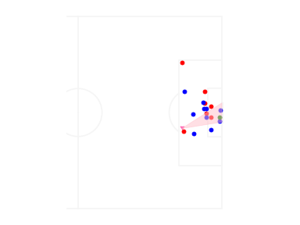


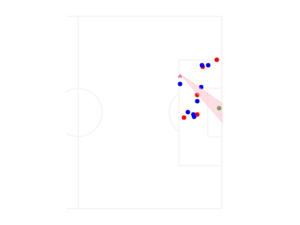
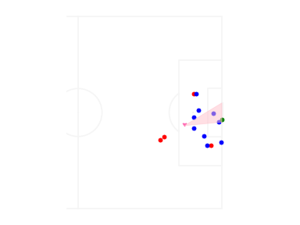


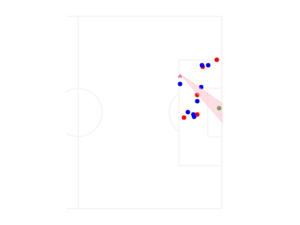
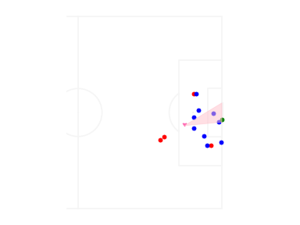


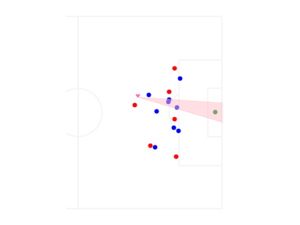
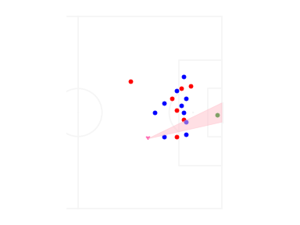


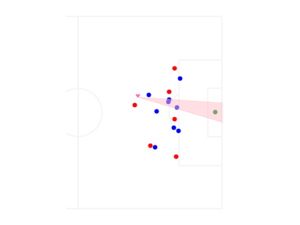
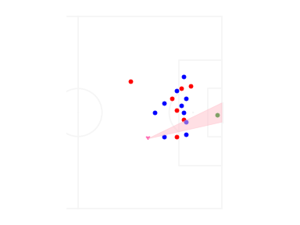


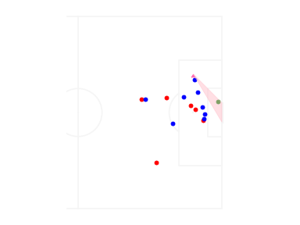
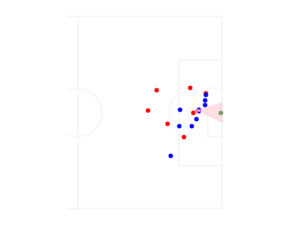


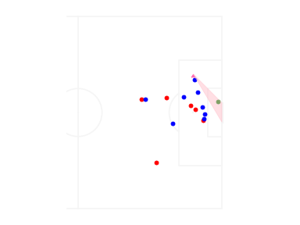
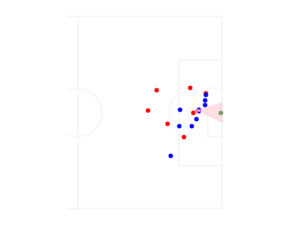


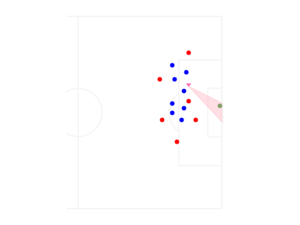
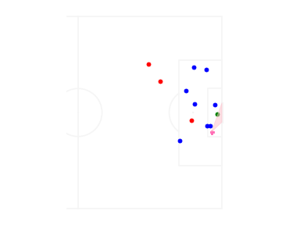


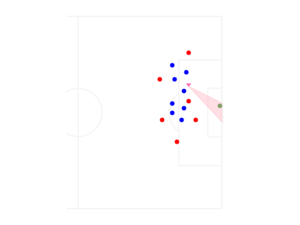
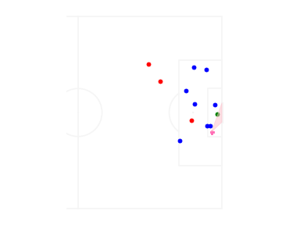


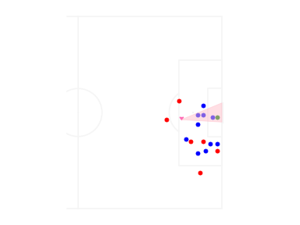
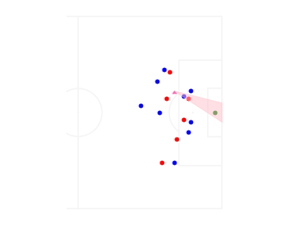


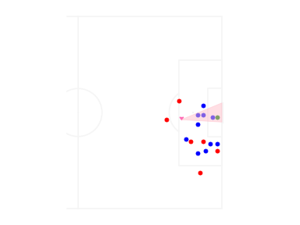
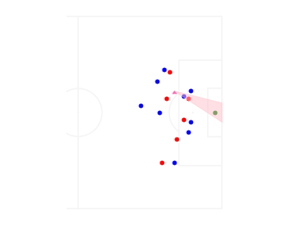


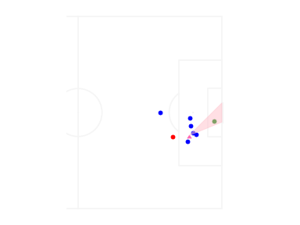
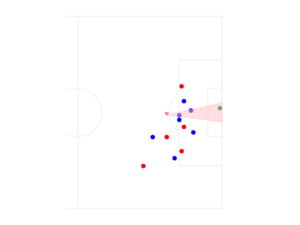


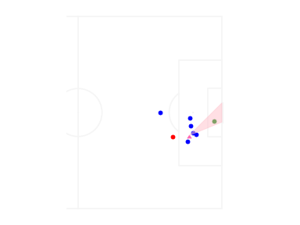
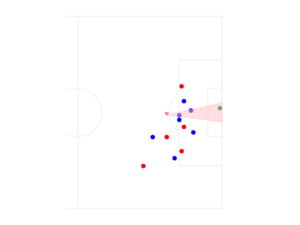


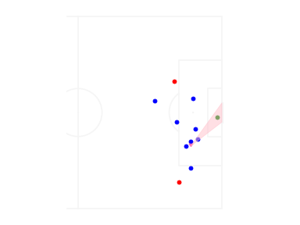
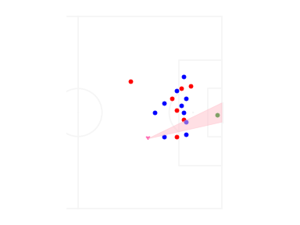


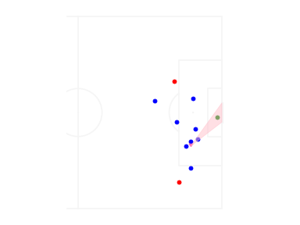
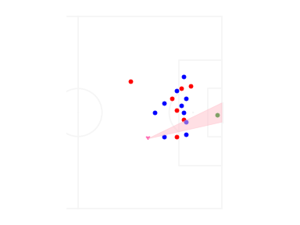

In [21]:
import ipyplot

# Find pairs of images with similar locations/SB-xG but different im-xG
crossed = pd.merge(
    predictions.assign(key=1),
    predictions.assign(key=1),
    how='outer',
    on=['key']
).loc[lambda df: df['xg_x'] > df['xg_y']]

pairs = crossed.loc[
    lambda df: np.abs(df['sb_xg_x'] - df['sb_xg_y']) < 0.02
].loc[
    lambda df: np.abs(df['xg_x'] - df['xg_y']) > 0.4
].sample(frac=1)

for _, p in pairs.head(50).iterrows():
    img1 = PILImage.create(p['path_x']).to_thumb(512, 512)
    img2 = PILImage.create(p['path_y']).to_thumb(512, 512)
    ipyplot.plot_class_representations(
        [img2, img1], 
        [f'Im: {p["xg_y"]:.2f}, SB: {p["sb_xg_y"]:.2f}, Goal: {p["is_goal_y"]}',
         f'Im: {p["xg_x"]:.2f}, SB: {p["sb_xg_x"]:.2f}, Goal: {p["is_goal_x"]}'],
        img_width=300
    )

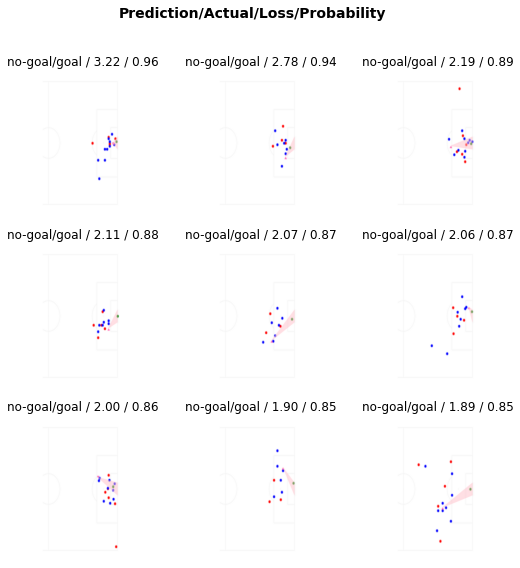

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

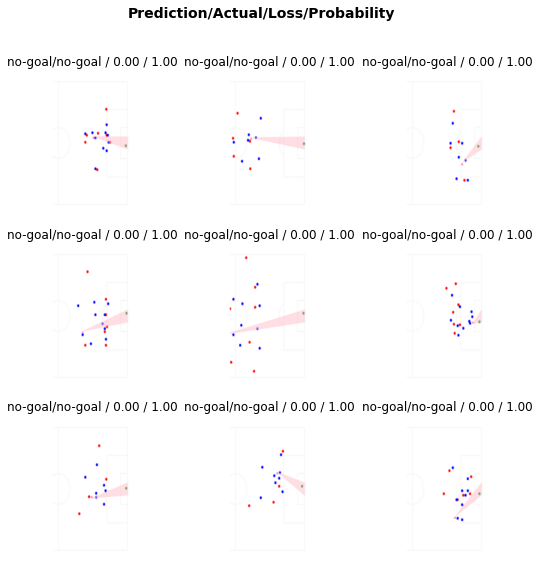

In [23]:
interp.plot_top_losses(9, largest=False)

CAM

In [24]:
def plot_cam_heatmap(image, ax=None):
    x, = first(dls.test_dl([image]))

    class Hook():
        def hook_func(self, m, i, o): 
            self.stored = o.detach().clone()

    hook_output = Hook()
    hook = learn.model[0].register_forward_hook(hook_output.hook_func)

    with torch.no_grad(): 
        output = learn.model.eval()(x)

    act = hook_output.stored[0]
    
    cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
    
    x_dec = TensorImage(dls.train.decode((x,))[0][0])

    if not ax:
        _, ax = plt.subplots()
    x_dec.show(ctx=ax)
    ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
                  interpolation='bilinear', cmap='magma')

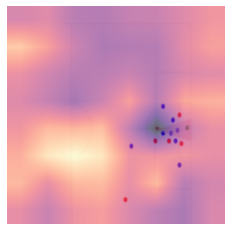

In [25]:
plot_cam_heatmap(example_img)
None

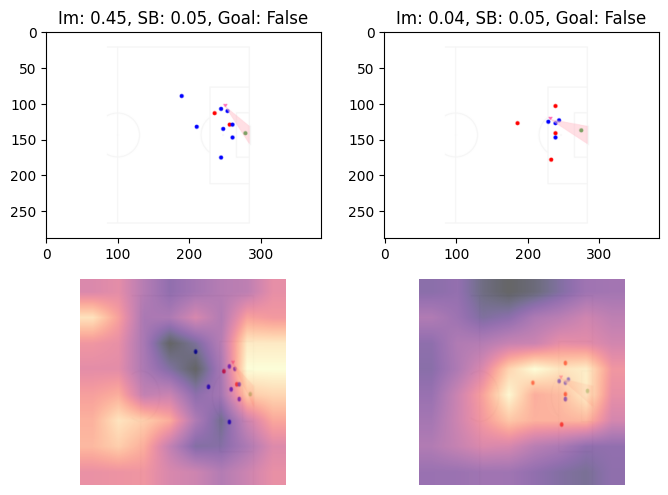

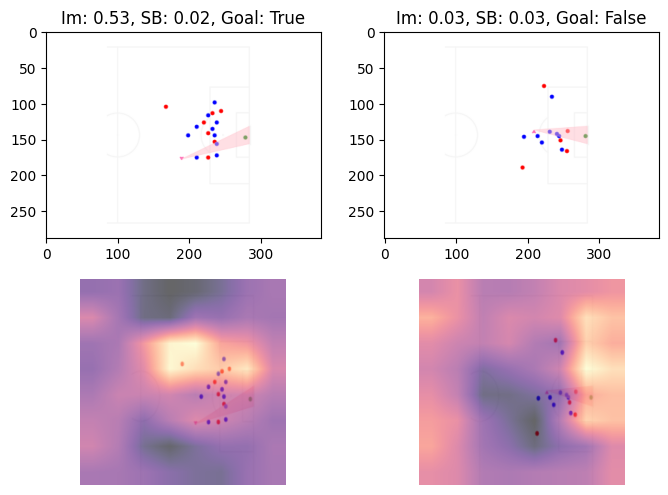

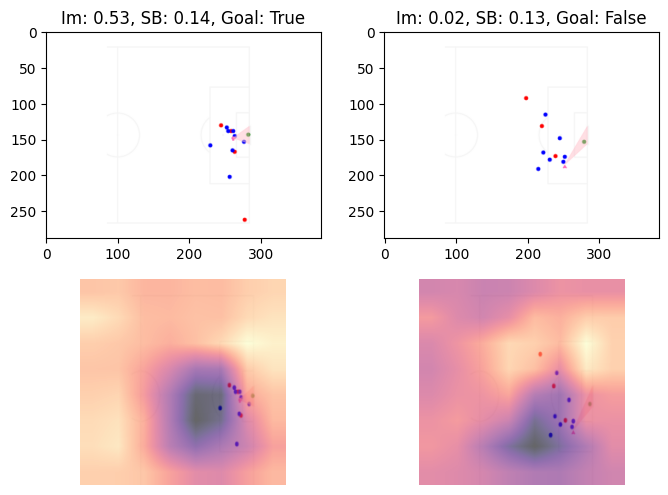

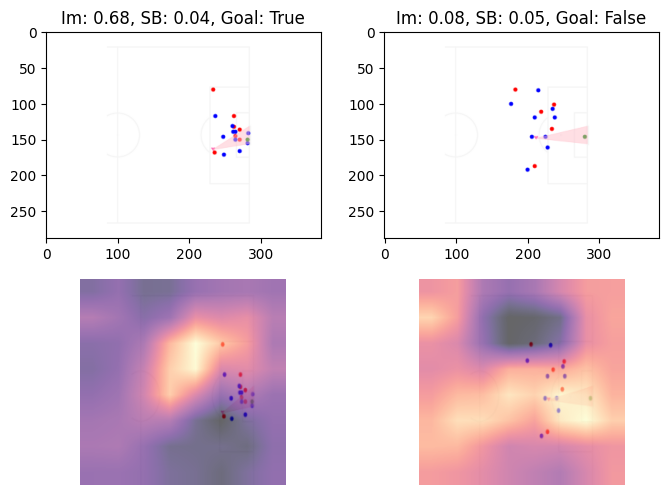

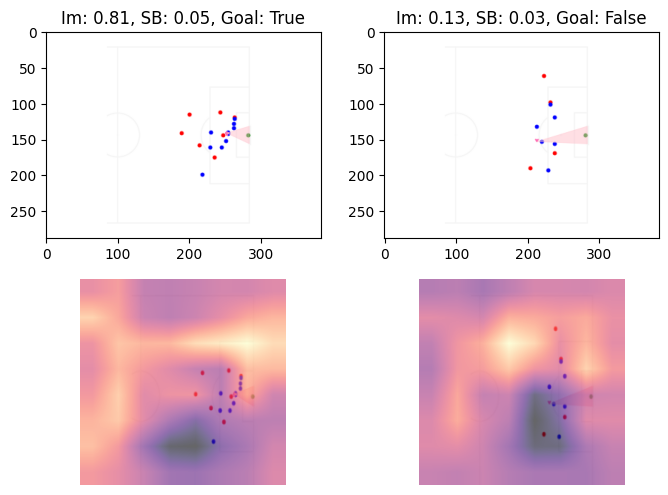

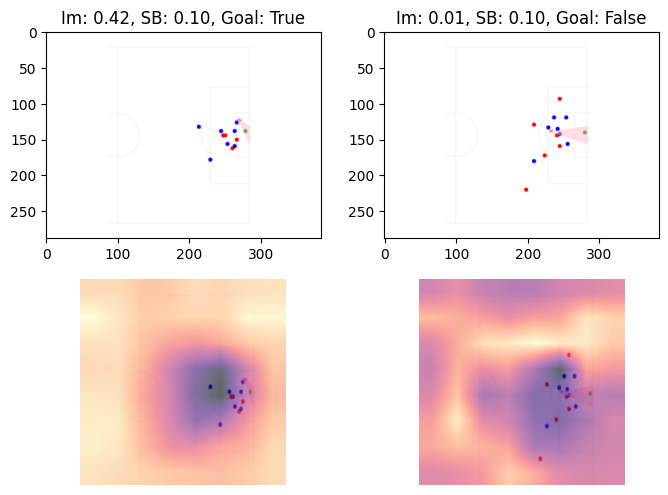

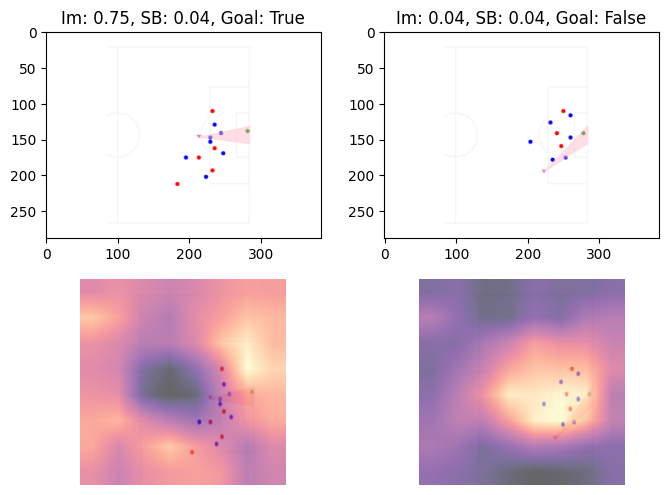

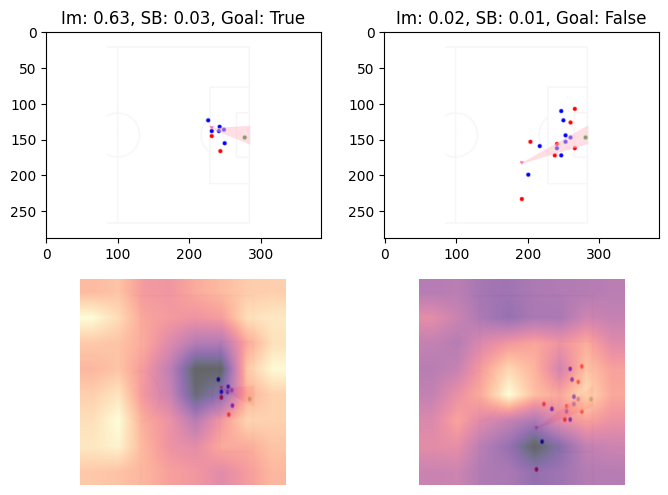

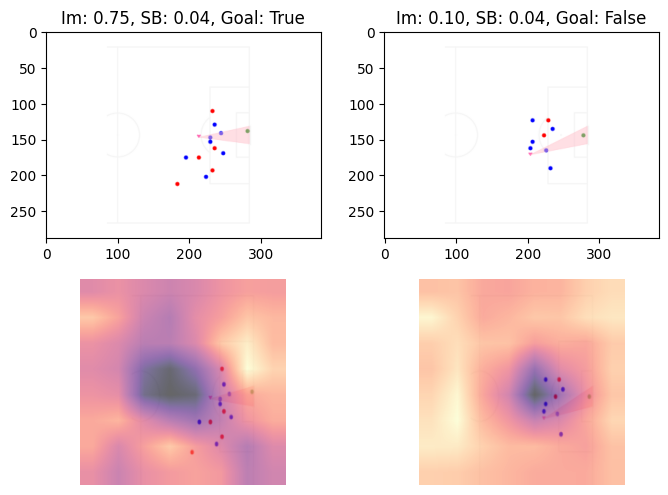

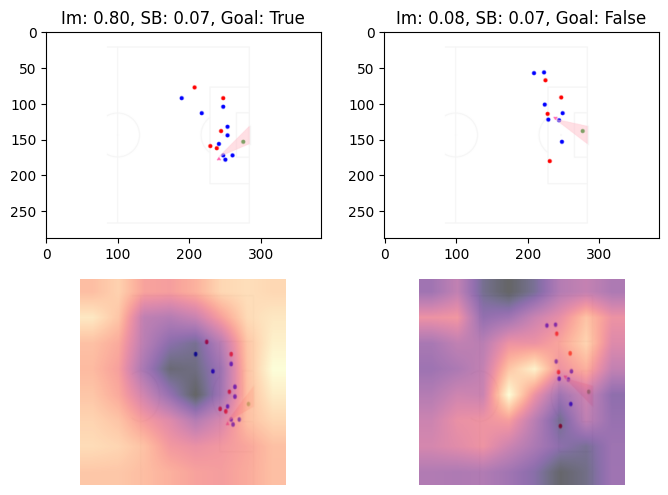

In [26]:
for _, p in pairs.sample(10).iterrows():
    img1 = PILImage.create(p['path_x'])
    img2 = PILImage.create(p['path_y'])

    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=100)

    ax[0, 0].set_title(f'Im: {p["xg_x"]:.2f}, SB: {p["sb_xg_x"]:.2f}, Goal: {p["is_goal_x"]}')
    ax[0, 0].imshow(img1)

    ax[0, 1].set_title(f'Im: {p["xg_y"]:.2f}, SB: {p["sb_xg_y"]:.2f}, Goal: {p["is_goal_y"]}')
    ax[0, 1].imshow(img2)

    plot_cam_heatmap(img1, ax[1, 0])
    plot_cam_heatmap(img2, ax[1, 1])